# mini BERT 만들기프로젝트

- vocab size를 8000으로 줄여 mini BERT 모델 작성


In [2]:
# -----------------------------------------------------------------------------
# 임포트
# -----------------------------------------------------------------------------
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import backend as K

%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


## 함수 및 클래스

In [91]:
# -----------------------------------------------------------------------------
# 토크나이저 및 데이터 전처리
# -----------------------------------------------------------------------------
def train_sentencepiece(corpus_file, model_prefix, vocab_size):
    """
    SentencePiece 모델을 훈련합니다.
    :param corpus_file: 말뭉치 파일 경로
    :param model_prefix: 출력 모델 파일 접두어
    :param vocab_size: 어휘 크기
    """
    spm.SentencePieceTrainer.train(
        f"--input={corpus_file} --model_prefix={model_prefix} "
        f"--vocab_size={vocab_size+7} --model_type=bpe --max_sentence_length=999999 "
        "--pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] "
        "--bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] "
        "--user_defined_symbols=[SEP],[CLS],[MASK]"
    )

def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    Masked LM을 위한 마스크를 생성합니다.
    :param tokens: 원본 토큰 리스트 (예: ["[CLS]", ...])
    :param mask_cnt: 마스크할 총 토큰 수
    :param vocab_list: 랜덤 토큰 선택용 리스트
    :return: (마스크 적용된 토큰 리스트, 마스크된 인덱스 리스트, 정답 레이블 리스트)
    """
    # 띄어쓰기 단위로 마스킹할 인덱스 그룹 생성
    cand_idx = []
    for i, t in enumerate(tokens):
        if t in ("[CLS]", "[SEP]"):
            continue
        if cand_idx and not t.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    random.shuffle(cand_idx)

    tokens_masked = tokens[:]
    mask_lms = []
    for group in cand_idx:
        if len(mask_lms) >= mask_cnt: break
        if len(mask_lms) + len(group) > mask_cnt: continue
        dice = random.random()
        for idx in group:
            if dice < 0.8:
                m = "[MASK]"
            elif dice < 0.9:
                m = tokens[idx]
            else:
                m = random.choice(vocab_list)
            mask_lms.append({"index": idx, "label": tokens[idx]})
            tokens_masked[idx] = m

    mask_lms.sort(key=lambda x: x["index"])
    mask_idx   = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]
    return tokens_masked, mask_idx, mask_label

def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    NSP와 MLM을 동시에 반영한 pretrain 인스턴스들을 생성합니다.
    :param vocab: SentencePieceProcessor
    :param doc:   한 문단의 토큰화된 라인 리스트
    :param n_seq: 최대 시퀀스 길이
    :param mask_prob: 마스크 확률 (예: 0.15)
    :param vocab_list: 랜덤 토큰 선택용 리스트
    :return: 생성된 인스턴스들의 리스트
    """
    max_seq = n_seq - 3
    instances, chunk, length = [], [], 0

    for i, line in enumerate(doc):
        chunk.append(line); length += len(line)
        if len(chunk)>1 and (i==len(doc)-1 or length>=max_seq):
            # 두 문장 A/B 분할
            split = random.randrange(1, len(chunk))
            tokens_a = sum(chunk[:split], [])
            tokens_b = sum(chunk[split:], [])
            # NSP 레이블
            is_next = 1 if random.random()>=0.5 else 0
            if is_next==0:
                tokens_a, tokens_b = tokens_b, tokens_a
            # 길이 조정
            while len(tokens_a)+len(tokens_b)>max_seq:
                if len(tokens_a)>len(tokens_b): tokens_a.pop(0)
                else: tokens_b.pop()
            # 토큰, 세그먼트 생성
            tokens  = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0]*(len(tokens_a)+2) + [1]*(len(tokens_b)+1)
            # 마스크 생성
            mask_cnt = int((len(tokens)-3)*mask_prob)
            tokens_m, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)
            instances.append({
                "tokens":     tokens_m,
                "segment":    segment,
                "is_next":    is_next,
                "mask_idx":   mask_idx,
                "mask_label": mask_label
            })
            chunk, length = [], 0

    return instances

def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """
    전체 말뭉치로부터 BERT pretrain용 JSONL 파일을 생성합니다.
    :param vocab: SentencePieceProcessor
    :param in_file: 입력 텍스트 파일 경로
    :param out_file: 출력 JSONL 파일 경로
    :param n_seq: 시퀀스 길이
    :param mask_prob: 마스크 확률
    """
    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = [
        vocab.id_to_piece(i) for i in range(7, len(vocab))
        if not vocab.is_unknown(i)
    ]
    line_count = sum(1 for _ in open(in_file))
    with open(in_file) as fr, open(out_file, "w") as fw:
        doc = []
        for line in tqdm(fr, total=line_count):
            txt = line.strip()
            if txt == "":
                if doc:
                    for inst in create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
                        fw.write(json.dumps(inst, ensure_ascii=False) + "\n")
                    doc = []
            else:
                pieces = vocab.encode_as_pieces(txt)
                if pieces:
                    doc.append(pieces)
        if doc:
            for inst in create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
                fw.write(json.dumps(inst, ensure_ascii=False) + "\n")

def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

# -----------------------------------------------------------------------------
# BERT 모델
# -----------------------------------------------------------------------------
def get_pad_mask(tokens, i_pad=0):
    """
    패딩 토큰에 대해 마스크를 생성합니다.
    :param tokens: (bs, n_seq) 입력 토큰 ID
    :param i_pad: PAD 토큰 ID
    :return: (bs, 1, n_seq) 패딩 부분이 1인 마스크
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    return tf.expand_dims(mask, 1)

@tf.function
def gelu(x):
    """
    GELU 활성화 함수 (tanh 근사)
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2/np.pi)*(x+0.044715*tf.pow(x,3))))

def kernel_initializer(stddev=0.02):
    """
    가중치 생성기 (TruncatedNormal)
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

def bias_initializer():
    """
    편향 생성기 (zeros)
    """
    return tf.zeros_initializer()

class Config(dict):
    """
    JSON 설정을 dict처럼 사용하기 위한 클래스
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        return Config(json.load(open(file)))

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Token Embedding과 출력 로짓을 공유하는 레이어
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        return tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))

    def _linear(self, inputs):
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq   = tf.shape(inputs)[1]
        flat    = tf.reshape(inputs, [-1, self.d_model])
        logits  = tf.matmul(flat, self.shared_weights, transpose_b=True)
        return tf.reshape(logits, [n_batch, n_seq, self.n_vocab])

class PositionEmbedding(tf.keras.layers.Layer):
    """
    위치 임베딩 레이어
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        self.embedding = tf.keras.layers.Embedding(
            config.n_seq, config.d_model,
            embeddings_initializer=kernel_initializer()
        )

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        return self.embedding(position)

class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale-dot-product attention 레이어
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # 점곱 및 스케일
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        # 마스크 적용
        attn_scale -= 1.e9 * attn_mask
        # softmax → attn_prob
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        # MAP 출력용 가중치를 저장
        self.last_attn = attn_prob
        
        return tf.matmul(attn_prob, V)

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi-head self-attention 레이어
    """
    def __init__(self, config, name="multi_head_attention"):
        super().__init__(name=name)
        self.d_model = config.d_model
        self.n_head  = config.n_head
        self.d_head  = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(
            config.n_head * config.d_head,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(
            config.n_head * config.d_head,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(
            config.n_head * config.d_head,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer())
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(
            config.d_model,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(
            tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]),
            [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(
            tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]),
            [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(
            tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]),
            [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m) # (bs, n_head, Q_len, d_head)
       # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3]) # (bs, Q_len, n_head, d_head)
        attn_flat  = tf.reshape(attn_out_m, [batch_size, -1, self.n_head * self.d_head]) # (bs, Q_len, d_model)
        return self.W_O(attn_flat) # (bs, Q_len, d_model)

class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position-wise feed-forward 네트워크
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        self.W_1 = tf.keras.layers.Dense(
            config.d_ff, activation=gelu,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(
            config.d_model,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer())

    def call(self, inputs):
        return self.W_2(self.W_1(inputs))

class EncoderLayer(tf.keras.layers.Layer):
    """
    Transformer encoder 한 레이어
    """
    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name)
        self.self_attention = MultiHeadAttention(config)
        self.norm1          = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        self.ffn            = PositionWiseFeedForward(config)
        self.norm2          = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        self.dropout        = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val     = self.norm1(enc_embed + self.dropout(self_attn_val))
        ffn_val       = self.ffn(norm1_val)
        return self.norm2(norm1_val + self.dropout(ffn_val))

class BERT(tf.keras.layers.Layer):
    """
    BERT 모델 전체
    """
    def __init__(self, config, name="bert"):
        super().__init__(name=name)
        self.i_pad           = config.i_pad
        self.embedding       = SharedEmbedding(config)
        self.position        = PositionEmbedding(config)
        self.segment         = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm            = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        self.encoder_layers  = [
            EncoderLayer(config, name=f"encoder_layer_{i}") 
            for i in range(config.n_layer)
        ]
        self.dropout         = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        enc_tokens, segments = inputs
        mask = get_pad_mask(enc_tokens, self.i_pad)
        emb  = (
            self.embedding(enc_tokens, mode="embedding") +
            self.position(enc_tokens) +
            self.segment(segments)
        )
        x    = self.dropout(self.norm(emb))
        for layer in self.encoder_layers:
            x = layer(x, mask)
        # CLS 로짓과 LM 로짓 생성
        logits_cls = x[:,0]
        logits_lm  = self.embedding(x, mode="linear")
        return logits_cls, logits_lm

class PooledOutput(tf.keras.layers.Layer):
    """
    NSP 분류용 pooled output
    """
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)
        self.dense1 = tf.keras.layers.Dense(
            config.d_model, activation=tf.nn.tanh,
            kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer()
        )
        self.dense2 = tf.keras.layers.Dense(
            n_output, use_bias=False, activation=tf.nn.softmax, name="nsp",
            kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer()
        )
 
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

def build_model_pre_train(config):
    """
    BERT pretrain 모델을 생성합니다.
    :param config: Config 객체
    :return: Keras Model (outputs: (nsp, mlm))
    """
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments   = tf.keras.layers.Input((None,), name="segments")

    logits_cls, logits_lm = BERT(config)((enc_tokens, segments))
    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)
    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    return tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))

# loss 기존코드와 다름  loss * mask * 20 -> tf.reduce_sum(loss * mask) * 20 / tf.maximum(tf.reduce_sum(mask), 1)
def lm_loss(y_true, y_pred):
    """
    Masked LM 손실 함수
    """
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), loss.dtype)
    return tf.reduce_sum(loss * mask) * 20 / tf.maximum(tf.reduce_sum(mask), 1)

def lm_acc(y_true, y_pred):
    """
    Masked LM 정확도 함수
    """
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches      = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    mask         = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    return tf.reduce_sum(matches * mask) / tf.maximum(tf.reduce_sum(mask), 1)

class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Cosine warmup/decay 학습률 스케줄러
    """
    def __init__(self, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        super().__init__()
        assert 0 < warmup_steps < train_steps
        self.train_steps  = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr       = max_lr

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warm = tf.cast(step <= self.warmup_steps, tf.float32)
        lr1  = step / self.warmup_steps
        prog = (step - self.warmup_steps) / tf.maximum(1.0, self.train_steps - self.warmup_steps)
        lr2  = 0.5 * (1 + tf.cos(math.pi * prog))
        return (warm * lr1 + (1 - warm) * lr2) * self.max_lr

# -----------------------------------------------------------------------------
# 추론 및 평가
# -----------------------------------------------------------------------------
# 그래프 모드로 변경된 predict_masked 함수
@tf.function(experimental_relax_shapes=True)
def predict_masked(tokens, mask_idx, model, vocab):
    """
    마스크된 토큰을 예측합니다. (그래프 모드)
    """
    seg = tf.zeros_like(tokens)
    inp = (tf.expand_dims(tokens, 0), tf.expand_dims(seg, 0))
    _, mlm_prob = model(inp, training=False)
    
    # attention weight 추출
    bert_layer = model.get_layer("bert")
    attn_weights = bert_layer.encoder_layers[0].self_attention.attention.last_attn[0]
    #avg_attn  = tf.reduce_mean(attn_weights, axis=0)  # (Q_len, K_len)
    
    pred_ids = tf.argmax(tf.gather(mlm_prob[0], mask_idx, axis=0), axis=-1)
    return pred_ids, attn_weights

# 그래프 모드로 변경된 predict_next_sentence 함수
@tf.function(experimental_relax_shapes=True)
def predict_next_sentence(tokens, segments, model):
    """
    두 문장의 연속 여부 확률을 예측합니다. (그래프 모드)
    """
    inp_arr = tf.expand_dims(tokens, 0)
    seg_arr = tf.expand_dims(segments, 0)
    prob, _ = model((inp_arr, seg_arr), training=False)
    
    # attention weight 추출
    bert_layer = model.get_layer("bert")
    attn_weights = bert_layer.encoder_layers[0].self_attention.attention.last_attn[0]
    #avg_attn  = tf.reduce_mean(attn_weights, axis=0)  # (Q_len, K_len)
    
    return prob[0, 1], attn_weights

def plot_attention_map(attn_weights, tokens, title="Attention Map"):
    """
    어텐션 맵을 히트맵으로 그립니다.
    """
    # PAD 토큰 제거하여 실제 의미있는 토큰만 표시
    non_pad_indices = [i for i, token in enumerate(tokens) if token != "[PAD]"]
    if len(non_pad_indices) > 20:  # 너무 많으면 상위 20개만
        non_pad_indices = non_pad_indices[:20]
    
    filtered_tokens = [tokens[i] for i in non_pad_indices]
    filtered_attn = attn_weights[0].numpy()[non_pad_indices][:, non_pad_indices]
    
    plt.figure(figsize=(max(8, len(filtered_tokens)*0.5), max(6, len(filtered_tokens)*0.4)))
    plt.imshow(filtered_attn, cmap='Blues', aspect='auto')
    plt.colorbar()
    
    # 토큰을 축에 표시
    plt.xticks(range(len(filtered_tokens)), filtered_tokens, rotation=45, ha='right')
    plt.yticks(range(len(filtered_tokens)), filtered_tokens)
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
def plot_attention_map_list(attentions, x_tokens_list, y_tokens_list, head=0, n_row=1, n_col=4, title="", xlabel="", ylabel=""):
    # 각 입력에 대한 어텐션 맵을 한 줄로 그리기
    fig, axes = plt.subplots(n_row, n_col, figsize=(5*n_col, n_row*5))
    
    for idx, ( nf_attn_weights, nf_x_tokens, nf_y_tokens) in enumerate(zip( attentions, x_tokens_list, y_tokens_list)):
        ax = axes[idx]
        
        # PAD 토큰 제거하여 실제 의미있는 토큰만 표시
        non_pad_indices_x = [i for i, token in enumerate(nf_x_tokens) if token != "[PAD]"]
        non_pad_indices_y = [i for i, token in enumerate(nf_y_tokens) if token != "[PAD]"]

        x_tokens = [nf_x_tokens[i] for i in non_pad_indices_x]
        y_tokens = [nf_y_tokens[i] for i in non_pad_indices_y]
        attn_weights = nf_attn_weights[head].numpy()[non_pad_indices_y][:, non_pad_indices_x]
        
        if len(attn_weights) > 0:
            # attn_weights는 벡터 리스트 (생성된 토큰당 하나씩)
            # 매트릭스로 스택 (generated_len, src_len)
            attn_matrix = np.stack(attn_weights, axis=0)
            
            im = ax.imshow(attn_matrix, aspect='auto', cmap='Blues', interpolation='nearest')
            
            # 라벨 설정
            if len(title) > 0:
                ax.set_title(title, fontsize=12, fontweight='bold')
            if len(xlabel) > 0:
                ax.set_xlabel(xlabel, fontsize=10)
            if len(ylabel) > 0:
                ax.set_ylabel(ylabel, fontsize=10)
            
            # X축: 소스 토큰 라벨 설정
            if len(x_tokens) <= 20:  # 토큰이 너무 많지 않을 때만 토큰 라벨 표시
                ax.set_xticks(range(len(x_tokens)))
                ax.set_xticklabels(x_tokens, rotation=45, ha='right', fontsize=8)
            
            # Y축: 생성된 토큰 라벨 설정
            if len(y_tokens) <= 20:  # 생성된 토큰이 너무 많지 않을 때만 라벨 표시
                ax.set_yticks(range(len(y_tokens)))
                ax.set_yticklabels(y_tokens, fontsize=8)
            
            # 각 서브플롯에 컬러바 추가
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
        else:
            ax.text(0.5, 0.5, '어텐션 데이터 없음', ha='center', va='center', transform=ax.transAxes)
            if len(title) > 0:
                ax.set_title(title, fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def plot_cls_attention_list(attentions, pa_list, pb_list,
                            n_row=1, n_col=None,
                            title_prefix=""):
    """
    여러 샘플에 대해 CLS→A/B 구간 어텐션 평균을 한 줄로 그립니다.
    
    :param attentions: 리스트 of tf.Tensor or np.ndarray, each (n_head, Q_len, K_len)
    :param pa_list:   리스트 of 문장 A의 piece 리스트
    :param pb_list:   리스트 of 문장 B의 piece 리스트
    :param n_row:     subplot 행 개수 (기본 1)
    :param n_col:     subplot 열 개수 (기본: len(attentions))
    :param title_prefix: 서브플롯 제목 앞부분 문자열
    """
    n = len(attentions)
    if n_col is None:
        n_col = n
    fig, axes = plt.subplots(n_row, n_col, figsize=(5*n_col, 4*n_row))
    axes = np.array(axes).reshape(-1)

    for i, (attn_w, pa, pb) in enumerate(zip(attentions, pa_list, pb_list)):
        ax = axes[i]
        # Tensor -> numpy
        aw = attn_w.numpy() if hasattr(attn_w, "numpy") else np.array(attn_w)
        n_head = aw.shape[0]
        
        # CLS(인덱스 0) → 전체 키에 대한 어텐션
        cls_attn = aw[:, 0, :]        # (n_head, K_len)

        # A/B 구간 인덱스 계산
        m, nB = len(pa), len(pb)
        a_start, a_end = 1, 1 + m
        b_start, b_end = a_end + 1, a_end + 1 + nB

        # 구간별 평균
        mean_A = cls_attn[:, a_start:a_end].mean(axis=1)
        mean_B = cls_attn[:, b_start:b_end].mean(axis=1)

        # 막대그래프
        x = np.arange(n_head)
        ax.bar(x - 0.2, mean_A, width=0.4, label="문장 A")
        ax.bar(x + 0.2, mean_B, width=0.4, label="문장 B")
        ax.set_xticks(x)
        ax.set_xticklabels([f"Head {j}" for j in x])
        ax.set_title(f"{title_prefix}샘플{i}")
        if i == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()
    
def test_pretrain_model(paragraph_str, model, vocab, mask_prob=0.15, n_seq=128):
    """
    간단한 문단으로 MLM 및 NSP 성능을 확인하고, 어텐션 가중치를 출력합니다.
    """
    sentences = [l.strip() for l in paragraph_str.split("\n") if l.strip()]

    # Masked LM 테스트
    for mask_group_count in (1, 2):
        total, correct = 0, 0
        print(f"\n=== Masked LM 테스트: {mask_group_count}개 그룹 마스킹 ===")
        attn_map_list = []
        tokens_list =[]

        for s in sentences:
            # 토크나이즈
            toks = vocab.encode_as_pieces(s)

            # 띄어쓰기(단어) 단위 그룹 생성
            cand_idx = []
            for i, t in enumerate(toks):
                if cand_idx and not t.startswith(u"\u2581"):
                    cand_idx[-1].append(i)
                else:
                    cand_idx.append([i])

            # 그룹 섞고 상위 mask_group_count개 그룹 선택
            random.shuffle(cand_idx)
            selected = cand_idx[:mask_group_count]
            mask_idxs = [idx for grp in selected for idx in grp]

            # 마스킹 적용
            masked = toks.copy()
            for idx in mask_idxs:
                masked[idx] = "[MASK]"

            # 예측 및 정답 판정
            ids = tf.constant([vocab.piece_to_id(t) for t in masked], dtype=tf.int32)
            mask_idxs_tf = tf.constant(mask_idxs, dtype=tf.int32)
            
            pred_ids, attn_weights = predict_masked(ids, mask_idxs_tf, model, vocab)
            preds = [vocab.id_to_piece(int(i)) for i in pred_ids.numpy()]
            
            # 어텐션 맵 저장 
            attn_map_list.append(attn_weights)
            tokens_list.append(masked)

            for idx, p in zip(mask_idxs, preds):
                total += 1
                if p == toks[idx]:
                    correct += 1

            print(f"\n원문:   {toks}")
            print(f"마스크: {masked}")
            print(f"예측:   {preds}")

        print(f"\nMLM 정확도 ({mask_group_count}그룹): "
              f"{correct}/{total} = {correct/total:.2%}")
        
        # 어텐션 맵 출력
        if len(attn_map_list) > 0  and len(tokens_list) > 0:
            for i in range(config.n_head):
                plot_attention_map_list(attn_map_list, tokens_list, tokens_list, head=i, n_col=5)
            attn_map_list = []
            tokens_list = []

    # NSP 테스트
    print("\n=== NSP 테스트 ===")
    t_corr, f_corr = 0, 0
    t_attn_map, f_attn_map = [], []
    t_tokens, f_tokens = [], []
    t_pa_list, t_pb_list = [], []
    f_pa_list, f_pb_list = [], []
    
    # True cases
    for i in range(len(sentences) - 1):
        a, b = sentences[i], sentences[i+1]
        pa, pb = vocab.encode_as_pieces(a), vocab.encode_as_pieces(b)
        
        # 토큰 및 세그먼트 준비
        cls_id, sep_id, pad_id = (
            vocab.piece_to_id("[CLS]"),
            vocab.piece_to_id("[SEP]"),
            vocab.pad_id()
        )
        
        inp = [cls_id] + [vocab.piece_to_id(p) for p in pa] + [sep_id] + [vocab.piece_to_id(p) for p in pb] + [sep_id]
        seg = [0]*(len(pa)+2) + [1]*(len(pb)+1)
        tokens_for_display = ["[CLS]"] + pa + ["[SEP]"] + pb + ["[SEP]"]
        
        # 패딩
        pad_len = n_seq - len(inp)
        if pad_len > 0:
            inp += [pad_id]*pad_len
            seg += [0]*pad_len
            tokens_for_display += ["[PAD]"]*pad_len
        else:
            inp = inp[:n_seq]
            seg = seg[:n_seq]
            tokens_for_display = tokens_for_display[:n_seq]
        
        tokens_tf = tf.constant(inp, dtype=tf.int32)
        segments_tf = tf.constant(seg, dtype=tf.int32)
        
        prob, attn_weights = predict_next_sentence(tokens_tf, segments_tf, model)
        prob_val = float(prob.numpy())
        
        print(f"T {i}->{i+1}: {prob_val:.2f}")
        if prob_val > 0.5:
            t_corr += 1
        
        # True case의 어텐션 맵 저장
        t_attn_map.append(attn_weights)
        t_tokens.append(tokens_for_display)
        t_pa_list.append(pa)
        t_pb_list.append(pb)
        
    # False cases
    for i in range(len(sentences) - 1):
        pa = vocab.encode_as_pieces(sentences[i])
        choices = [j for j in range(len(sentences)) if j != i+1]
        j = random.choice(choices)
        pb = vocab.encode_as_pieces(sentences[j])
        
        # 토큰 및 세그먼트 준비
        inp = [cls_id] + [vocab.piece_to_id(p) for p in pa] + [sep_id] + [vocab.piece_to_id(p) for p in pb] + [sep_id]
        seg = [0]*(len(pa)+2) + [1]*(len(pb)+1)
        tokens_for_display = ["[CLS]"] + pa + ["[SEP]"] + pb + ["[SEP]"]
        
        # 패딩
        pad_len = n_seq - len(inp)
        if pad_len > 0:
            inp += [pad_id]*pad_len
            seg += [0]*pad_len
            tokens_for_display += ["[PAD]"]*pad_len
        else:
            inp = inp[:n_seq]
            seg = seg[:n_seq]
            tokens_for_display = tokens_for_display[:n_seq]
        
        tokens_tf = tf.constant(inp, dtype=tf.int32)
        segments_tf = tf.constant(seg, dtype=tf.int32)
        
        prob, attn_weights = predict_next_sentence(tokens_tf, segments_tf, model)
        prob_val = float(prob.numpy())
        
        print(f"F {i}->{j}: {prob_val:.2f}")
        if prob_val < 0.5:
            f_corr += 1
        
        # False case의 어텐션 맵 저장

        f_attn_map.append(attn_weights)
        f_tokens.append(tokens_for_display)
        f_pa_list.append(pa)
        f_pb_list.append(pb)
    
    n = len(sentences) - 1
    print(f"NSP 정확도: True {t_corr}/{n}, False {f_corr}/{n}")
    plot_cls_attention_list(t_attn_map,t_pa_list,t_pb_list)
    plot_cls_attention_list(f_attn_map,f_pa_list,f_pb_list)
    t_pa_list, t_pb_list = [], []
    f_pa_list, f_pb_list = [], []
    
    # NSP 어텐션 맵 출력
    if len(t_attn_map) > 0  and len(t_tokens) > 0:
        for i in range(config.n_head):
            plot_attention_map_list(t_attn_map, t_tokens, t_tokens, head=i)
            
        t_attn_map = []
        t_tokens = []
    
    if len(f_attn_map) > 0  and len(f_tokens) > 0:
        for i in range(config.n_head):
            plot_attention_map_list(f_attn_map, f_tokens, f_tokens, head=i)
        f_attn_map = []
        f_tokens = []


## tokenizer 준비
- vocab 8000개 sentencepiece 준비
- console에서 미리 생성
- log 
```
sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/bert_pretrain/data/kowiki.txt --model_prefix=/aiffel/aiffel/bert_pretrain/models/ko_8000 --vocab_size=8007 --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/bert_pretrain/data/kowiki.txt
  input_format: 
  model_prefix: /aiffel/aiffel/bert_pretrain/models/ko_8000
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [SEP]
  user_defined_symbols: [CLS]
  user_defined_symbols: [MASK]
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: [UNK]
  bos_piece: [BOS]
  eos_piece: [EOS]
  pad_piece: [PAD]
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: /aiffel/aiffel/bert_pretrain/data/kowiki.txt
trainer_interface.cc(140) LOG(INFO) Loaded 1000000 lines
trainer_interface.cc(140) LOG(INFO) Loaded 2000000 lines
trainer_interface.cc(117) LOG(WARNING) Too many sentences are loaded! (2451287), which may slow down training.
trainer_interface.cc(119) LOG(WARNING) Consider using --input_sentence_size=<size> and --shuffle_input_sentence=true.
trainer_interface.cc(122) LOG(WARNING) They allow to randomly sample <size> sentences from the entire corpus.
trainer_interface.cc(385) LOG(INFO) Loaded all 2451287 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: [PAD]
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: [UNK]
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: [BOS]
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: [EOS]
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: [SEP]
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: [CLS]
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: [MASK]
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=287452241
trainer_interface.cc(477) LOG(INFO) Done: 99.95% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=4411
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.9995
trainer_interface.cc(520) LOG(INFO) Done! preprocessed 2450254 sentences.
trainer_interface.cc(526) LOG(INFO) Tokenizing input sentences with whitespace: 2450254
trainer_interface.cc(537) LOG(INFO) Done! 7050692
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=1781571 min_freq=424
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=576838 size=20 all=581927 active=38577 piece=▁아
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=390836 size=40 all=591445 active=48095 piece=▁유
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=297873 size=60 all=601378 active=58028 piece=에는
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=244712 size=80 all=609974 active=66624 piece=▁성
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=194372 size=100 all=616449 active=73099 piece=까지
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=193674 min_freq=462
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=176838 size=120 all=625299 active=38770 piece=▁우
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=154294 size=140 all=632274 active=45745 piece=▁파
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=140625 size=160 all=639734 active=53205 piece=00
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=125983 size=180 all=645481 active=58952 piece=▁요
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=114855 size=200 all=649839 active=63310 piece=리아
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=114086 min_freq=457
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=106760 size=220 all=657338 active=39316 piece=▁같은
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=100770 size=240 all=662564 active=44542 piece=▁왕
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=96037 size=260 all=670536 active=52514 piece=▁목
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=88392 size=280 all=675441 active=57419 piece=▁f
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=81678 size=300 all=681701 active=63679 piece=▁선수
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=80870 min_freq=446
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=77144 size=320 all=686930 active=39163 piece=▁때문에
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=73218 size=340 all=691000 active=43233 piece=▁조선
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=68829 size=360 all=695717 active=47950 piece=▁천
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=64009 size=380 all=700839 active=53072 piece=▁196
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=60953 size=400 all=706675 active=58908 piece=▁돌
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=60762 min_freq=435
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=58542 size=420 all=711350 active=39712 piece=▁다시
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=55779 size=440 all=715377 active=43739 piece=▁K
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=52528 size=460 all=721839 active=50201 piece=▁모두
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=49784 size=480 all=727356 active=55718 piece=▁히
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=47637 size=500 all=733038 active=61400 piece=▁전쟁
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=47558 min_freq=423
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=45919 size=520 all=738287 active=41703 piece=▁있어
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=44025 size=540 all=743886 active=47302 piece=▁중심
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=42378 size=560 all=748357 active=51773 piece=▁N
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=40922 size=580 all=752114 active=55530 piece=▁H
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=39922 size=600 all=755142 active=58558 piece=le
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=39768 min_freq=414
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=38924 size=620 all=761204 active=43650 piece=▁검
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=37771 size=640 all=767376 active=49822 piece=란드
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=36292 size=660 all=772837 active=55283 piece=정을
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=35134 size=680 all=778715 active=61161 piece=▁설립
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=34016 size=700 all=783719 active=66165 piece=▁역사
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=34003 min_freq=400
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=33144 size=720 all=787243 active=42507 piece=▁만들어
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=32383 size=740 all=791538 active=46802 piece=▁시간
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=31645 size=760 all=795131 active=50395 piece=▁측
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=30941 size=780 all=798845 active=54109 piece=과의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=30041 size=800 all=803050 active=58314 piece=도는
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=30023 min_freq=392
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=29448 size=820 all=808546 active=45099 piece=▁난
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=28836 size=840 all=813895 active=50448 piece=▁21
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=28270 size=860 all=818654 active=55207 piece=▁찾
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=27299 size=880 all=824625 active=61177 piece=되지
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=26862 size=900 all=828285 active=64837 piece=하자
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=26833 min_freq=381
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=26060 size=920 all=832595 active=45199 piece=부에
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=25504 size=940 all=838824 active=51428 piece=수의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=24726 size=960 all=843322 active=55926 piece=▁남아
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=24083 size=980 all=848416 active=61020 piece=▁않는다
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=23647 size=1000 all=853601 active=66205 piece=인민
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=23602 min_freq=368
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=23176 size=1020 all=859529 active=48367 piece=▁마지
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=22849 size=1040 all=863129 active=51967 piece=▁시리즈
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=22293 size=1060 all=868678 active=57516 piece=제로
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=21851 size=1080 all=873075 active=61913 piece=시의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=21377 size=1100 all=878277 active=67115 piece=해야
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=21369 min_freq=355
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=21043 size=1120 all=882003 active=47093 piece=▁녹
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=20625 size=1140 all=886266 active=51356 piece=▁인구는
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=20185 size=1160 all=889382 active=54472 piece=ac
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=19762 size=1180 all=894738 active=59828 piece=인은
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=19447 size=1200 all=899565 active=64655 piece=50
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=19432 min_freq=347
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=19118 size=1220 all=903215 active=48471 piece=광역
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=18777 size=1240 all=908007 active=53263 piece=수는
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=18396 size=1260 all=913268 active=58524 piece=인민공
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=18040 size=1280 all=917389 active=62645 piece=▁긴
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=17659 size=1300 all=922177 active=67433 piece=▁전통
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=17629 min_freq=335
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=17404 size=1320 all=926354 active=50086 piece=▁망
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=17093 size=1340 all=929494 active=53226 piece=단의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=16931 size=1360 all=934269 active=58001 piece=▁인간
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=16719 size=1380 all=939872 active=63604 piece=▁바로
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=16586 size=1400 all=943447 active=67179 piece=▁탑
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=16584 min_freq=327
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=16331 size=1420 all=947545 active=51069 piece=▁태양
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=16086 size=1440 all=952041 active=55565 piece=▁경기에서
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=15873 size=1460 all=957568 active=61092 piece=▁동일
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=15577 size=1480 all=962681 active=66205 piece=드를
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=15352 size=1500 all=966310 active=69834 piece=▁뮤
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=15328 min_freq=318
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=15103 size=1520 all=968851 active=50741 piece=id
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=14971 size=1540 all=972545 active=54435 piece=▁옥
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=14723 size=1560 all=977306 active=59196 piece=비전
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=14495 size=1580 all=982182 active=64072 piece=▁대부분의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=14292 size=1600 all=985970 active=67860 piece=▁갑
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=14280 min_freq=311
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=14118 size=1620 all=990010 active=53173 piece=회는
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=13982 size=1640 all=993514 active=56677 piece=▁사고
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=13729 size=1660 all=997224 active=60387 piece=cm
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=13567 size=1680 all=1001600 active=64762 piece=▁뛰어
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=13433 size=1700 all=1006574 active=69736 piece=▁더욱
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=13420 min_freq=303
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=13135 size=1720 all=1011076 active=54820 piece=지역
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=12940 size=1740 all=1015431 active=59175 piece=▁선언
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=12821 size=1760 all=1020339 active=64083 piece=▁어려
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=12640 size=1780 all=1023221 active=66965 piece=▁칭
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=12505 size=1800 all=1028177 active=71921 piece=▁옛
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=12503 min_freq=295
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=12409 size=1820 all=1033793 active=56931 piece=ce
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=12253 size=1840 all=1037183 active=60321 piece=▁그들의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=12091 size=1860 all=1041900 active=65038 piece=▁단체
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=11934 size=1880 all=1045379 active=68517 piece=▁예술
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=11799 size=1900 all=1048007 active=71145 piece=라의
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=11799 min_freq=288
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=11693 size=1920 all=1050313 active=54358 piece=▁불구하고
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=11594 size=1940 all=1053703 active=57748 piece=▁분리
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=11496 size=1960 all=1057998 active=62043 piece=▁사이의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=11381 size=1980 all=1063418 active=67463 piece=단이
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=11289 size=2000 all=1067885 active=71930 piece=im
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=11277 min_freq=281
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=11133 size=2020 all=1071888 active=57167 piece=▁등과
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10994 size=2040 all=1077153 active=62432 piece=법을
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10895 size=2060 all=1081334 active=66613 piece=▁괴
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10776 size=2080 all=1084885 active=70164 piece=러스
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10692 size=2100 all=1089330 active=74609 piece=▁깨
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=10688 min_freq=274
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10597 size=2120 all=1091576 active=56585 piece=릭터
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10496 size=2140 all=1095180 active=60189 piece=▁확장
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10396 size=2160 all=1100510 active=65519 piece=었던
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10271 size=2180 all=1104334 active=69343 piece=▁남부
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10143 size=2200 all=1108628 active=73637 piece=▁스포츠
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=10136 min_freq=268
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=10057 size=2220 all=1111848 active=58430 piece=▁이외
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9957 size=2240 all=1115235 active=61817 piece=▁서식
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9848 size=2260 all=1120216 active=66798 piece=▁작용
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9732 size=2280 all=1124443 active=71025 piece=▁이야기
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9655 size=2300 all=1129106 active=75688 piece=▁성립
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=9653 min_freq=261
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9570 size=2320 all=1132064 active=59284 piece=▁떨어진
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9473 size=2340 all=1135883 active=63103 piece=시를
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9352 size=2360 all=1139681 active=66901 piece=▁히로
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9289 size=2380 all=1142636 active=69856 piece=▁부정
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9219 size=2400 all=1147544 active=74764 piece=▁2020
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=9217 min_freq=256
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9137 size=2420 all=1150230 active=60032 piece=▁상징
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9028 size=2440 all=1153890 active=63692 piece=▁1950
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8965 size=2460 all=1157151 active=66953 piece=▁표시
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8889 size=2480 all=1162268 active=72070 piece=▁사용된다
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8828 size=2500 all=1165804 active=75606 piece=▁아일랜드
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=8826 min_freq=251
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8738 size=2520 all=1169223 active=61615 piece=▁동생
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8694 size=2540 all=1173546 active=65938 piece=ie
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8641 size=2560 all=1176802 active=69194 piece=▁경상북도
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8570 size=2580 all=1180886 active=73278 piece=▁계승
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8489 size=2600 all=1184747 active=77139 piece=▁1985
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=8487 min_freq=246
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8434 size=2620 all=1188193 active=62666 piece=력의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8345 size=2640 all=1191415 active=65888 piece=인지
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8270 size=2660 all=1196857 active=71330 piece=▁달성
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8223 size=2680 all=1200791 active=75264 piece=▁충돌
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8139 size=2700 all=1202837 active=77310 piece=ak
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=8133 min_freq=241
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8061 size=2720 all=1205959 active=63019 piece=▁2,
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=8008 size=2740 all=1208089 active=65149 piece=)"
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7956 size=2760 all=1210710 active=67770 piece=▁둘러
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7894 size=2780 all=1213790 active=70850 piece=워드
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7817 size=2800 all=1216934 active=73994 piece=▁즐
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=7817 min_freq=237
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7753 size=2820 all=1220480 active=64363 piece=석을
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7703 size=2840 all=1224543 active=68426 piece=인들은
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7656 size=2860 all=1229199 active=73082 piece=▁MBC
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7587 size=2880 all=1232852 active=76735 piece=산의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7529 size=2900 all=1238593 active=82476 piece=생활
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=7526 min_freq=232
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7474 size=2920 all=1244080 active=66850 piece=년대에
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7408 size=2940 all=1248652 active=71422 piece=▁아우
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7352 size=2960 all=1252722 active=75492 piece=▁대회에서
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7304 size=2980 all=1256113 active=78883 piece=프가
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7254 size=3000 all=1258582 active=81352 piece=가가
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=7254 min_freq=227
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7200 size=3020 all=1262333 active=66190 piece=▁출발
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7130 size=3040 all=1266484 active=70341 piece=주가
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7087 size=3060 all=1270279 active=74136 piece=▁경우도
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7049 size=3080 all=1274031 active=77887 piece=▁전개
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7000 size=3100 all=1277747 active=81603 piece=대전
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=6999 min_freq=222
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6941 size=3120 all=1279813 active=65635 piece=ell
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6902 size=3140 all=1283065 active=68887 piece=트라
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6853 size=3160 all=1286899 active=72721 piece=음악
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6817 size=3180 all=1290334 active=76156 piece=▁성우
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6770 size=3200 all=1293860 active=79682 piece=▁구역
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=6770 min_freq=219
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6707 size=3220 all=1297078 active=67788 piece=일보
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6660 size=3240 all=1301117 active=71827 piece=트에
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6617 size=3260 all=1304163 active=74873 piece=▁라이브
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6579 size=3280 all=1308287 active=78997 piece=▁이끄는
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6549 size=3300 all=1311934 active=82644 piece=▁1976
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=6547 min_freq=214
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6517 size=3320 all=1314193 active=67834 piece=▁방식으로
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6480 size=3340 all=1317604 active=71245 piece=▁설치되어
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6448 size=3360 all=1321261 active=74902 piece=...
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6408 size=3380 all=1323725 active=77366 piece=초등학교는
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6385 size=3400 all=1327377 active=81018 piece=▁고구려
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=6380 min_freq=211
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6352 size=3420 all=1329508 active=68387 piece=▁이스라엘
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6312 size=3440 all=1333149 active=72028 piece=▁초반
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6272 size=3460 all=1336419 active=75298 piece=싱턴
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6227 size=3480 all=1339417 active=78296 piece=오프
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6191 size=3500 all=1341801 active=80680 piece=시와
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=6191 min_freq=208
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6155 size=3520 all=1344660 active=69389 piece=▁잭
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6115 size=3540 all=1347440 active=72169 piece=지면서
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6075 size=3560 all=1350874 active=75603 piece=세계
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=6049 size=3580 all=1355093 active=79822 piece=받은
trainer_interface.cc(615) LOG(INFO) Saving model: /aiffel/aiffel/bert_pretrain/models/ko_8000.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: /aiffel/aiffel/bert_pretrain/models/ko_8000.vocab
```

In [4]:
corpus_file  = os.getenv('HOME') + '/aiffel/bert_pretrain/data/kowiki.txt'
model_prefix = os.getenv('HOME') + '/aiffel/bert_pretrain/models/ko_8000'

if not os.path.exists(model_prefix + '.model'):
    train_sentencepiece(corpus_file, model_prefix, vocab_size=8000)

vocab = spm.SentencePieceProcessor()
vocab.load(model_prefix + '.model')

True

## Vocab 확인
- sentencepiece_trainer log 와 일치 확인
- 샘플 토큰 확인 - 줄어든 vocab size 로 인해 토큰이 더 작은 작게 서브워드 분할됨

In [5]:
print("Vocab size:", len(vocab))       # 전체 vocab 크기
# 특수 토큰 ID 확인
for t in ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]:
    print(f"{t} →", vocab.piece_to_id(t))
# 앞쪽 토큰 샘플 출력
print("Sample tokens:", [vocab.id_to_piece(i) for i in range(7,11)])

string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

Vocab size: 8007
[PAD] → 0
[UNK] → 1
[CLS] → 5
[SEP] → 4
[MASK] → 6
Sample tokens: ['▁1', '▁이', '으로', '에서']
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


## pretrain 데이터 생성

In [7]:
pretrain_json = os.getenv('HOME') + '/aiffel/bert_pretrain/data/bert_pre_train_8000.json'
if not os.path.exists(pretrain_json):
    make_pretrain_data(vocab, corpus_file, pretrain_json, n_seq=128, mask_prob=0.15)

## pretrain 데이터 로드


In [8]:
(pre_train_inputs, pre_train_labels) = load_pre_train_data(
    vocab, pretrain_json, n_seq=128, count=None
)

  0%|          | 0/918189 [00:00<?, ?it/s]

/tmp/ipykernel_62/4034161149.py:177: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_62/4034161149.py:178: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

## pretrain 데이터 확인

In [9]:
enc_tokens, segments = pre_train_inputs
labels_nsp, labels_mlm = pre_train_labels

# 형태 일관성 확인
assert enc_tokens.shape == segments.shape == labels_mlm.shape, (
    f"Shape mismatch: enc_tokens={enc_tokens.shape}, "
    f"segments={segments.shape}, labels_mlm={labels_mlm.shape}"
)
assert labels_nsp.shape[0] == enc_tokens.shape[0], (
    f"labels_nsp length {labels_nsp.shape[0]} != instances {enc_tokens.shape[0]}"
)

print(f"✔ 총 인스턴스 수: {enc_tokens.shape[0]}, 시퀀스 길이: {enc_tokens.shape[1]}")

# 첫 번째 및 마지막 인스턴스 확인
i_first, i_last = 0, enc_tokens.shape[0] - 1

print("\n--- 첫 번째 인스턴스 ---")
print("enc_tokens :", enc_tokens[i_first])
print("segments   :", segments[i_first])
print("labels_nsp :", labels_nsp[i_first])
print("labels_mlm :", labels_mlm[i_first])

print("\n--- 마지막 인스턴스 ---")
print("enc_tokens :", enc_tokens[i_last])
print("segments   :", segments[i_last])
print("labels_nsp :", labels_nsp[i_last])
print("labels_mlm :", labels_mlm[i_last])

✔ 총 인스턴스 수: 918189, 시퀀스 길이: 128

--- 첫 번째 인스턴스 ---
enc_tokens : [   5   10 1605 3599 1755 3630   41 3644  830 3624 1135   52 3599   13
   81   87 1501 2247   25 3779 3873 3667 3631 3813 3873 4196 3636 3779
 3601  249 3725 1232   33   52 3599    6    6    6 6322 2780   14 1509
  168 3877  414  165 1697 4290 3873 3703 3683  593   21 5007  399 1927
 3607    6    6    6    6    6    6  103 4313 4290  613 3638 3718   98
 3878 3656  256 2543  309  337 3735  181 3616 3603  489  376 3599    4
    6    6  207 3714    6 1042  103 3610 3686 3718    6    6   37 3418
  416  810 3666 3625  131 3662    7 3629  203  241 3602 1114 3724  788
  243    6    6    6  663 1647 3682 3682 3625  203 3008 3625 3616   16
 3599    4]
segments   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
labels_nsp 

##  BERT 모델 구현

In [10]:
config = Config({
    "d_model":256, "n_head":4, "d_head":64, "dropout":0.1,
    "d_ff":1024, "layernorm_epsilon":1e-12,
    "n_layer":3, "n_seq":128, "n_vocab":len(vocab),
    "i_pad":vocab.pad_id()
})
model = build_model_pre_train(config)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4452864     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                   

In [12]:
len(pre_train_inputs[0])

918189

In [13]:
epochs = 10
batch_size = 64

train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
lr_sched = CosineSchedule(train_steps=train_steps, warmup_steps=train_steps // 10)
optimizer = tf.keras.optimizers.Adam(lr_sched, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(
    optimizer=optimizer,
    loss=(tf.keras.losses.SparseCategoricalCrossentropy(), lm_loss),
    metrics={"nsp": "acc", "mlm": lm_acc}
)

## pretrain 진행

In [13]:
history = model.fit(
    pre_train_inputs,
    pre_train_labels,
    epochs=10,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "mini_bert_8000.h5",
            monitor="mlm_lm_acc",
            save_best_only=True,
            mode="max",
            save_weights_only=True
        )
    ]
)

Epoch 1/10
14347/14347 [==============================] - 2075s 144ms/step - loss: 129.0483 - nsp_loss: 0.5623 - mlm_loss: 128.4863 - nsp_acc: 0.7114 - mlm_lm_acc: 0.1395
Epoch 2/10
14347/14347 [==============================] - 2071s 144ms/step - loss: 90.9040 - nsp_loss: 0.5204 - mlm_loss: 90.3839 - nsp_acc: 0.7480 - mlm_lm_acc: 0.2624
Epoch 3/10
14347/14347 [==============================] - 2073s 144ms/step - loss: 83.4478 - nsp_loss: 0.5117 - mlm_loss: 82.9360 - nsp_acc: 0.7563 - mlm_lm_acc: 0.3015
Epoch 4/10
14347/14347 [==============================] - 2071s 144ms/step - loss: 80.5177 - nsp_loss: 0.5077 - mlm_loss: 80.0104 - nsp_acc: 0.7601 - mlm_lm_acc: 0.3171
Epoch 5/10
14347/14347 [==============================] - 2070s 144ms/step - loss: 78.6495 - nsp_loss: 0.5049 - mlm_loss: 78.1449 - nsp_acc: 0.7634 - mlm_lm_acc: 0.3274
Epoch 6/10
14347/14347 [==============================] - 2072s 144ms/step - loss: 77.1914 - nsp_loss: 0.5032 - mlm_loss: 76.6881 - nsp_acc: 0.7657 - mlm

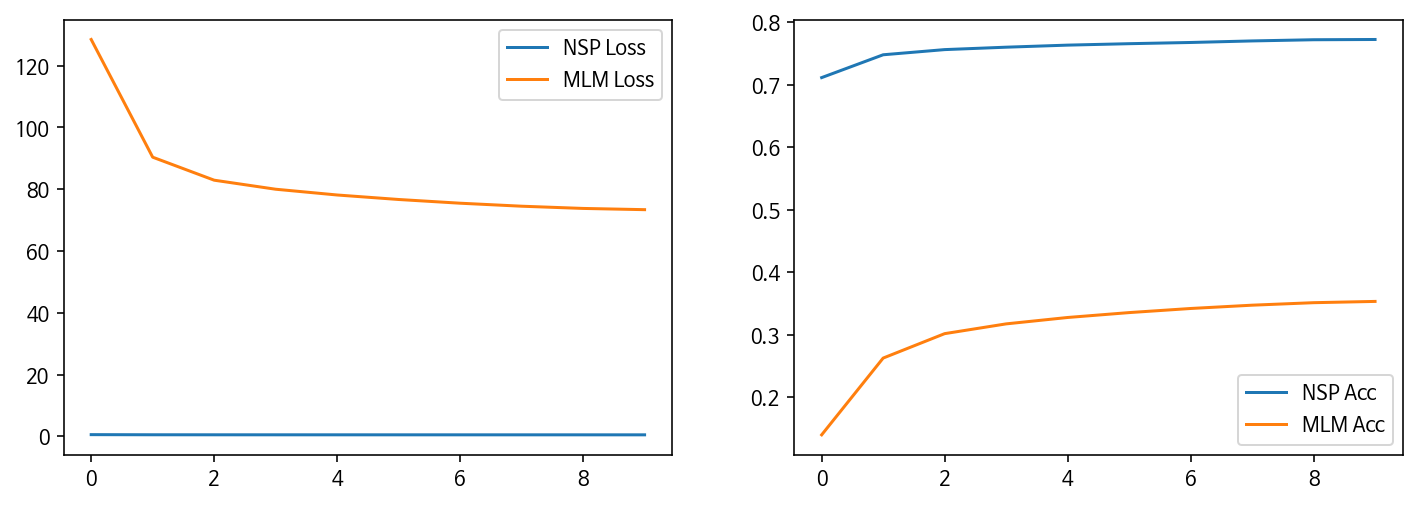

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], label='NSP Loss')
plt.plot(history.history['mlm_loss'], label='MLM Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], label='NSP Acc')
plt.plot(history.history['mlm_lm_acc'], label='MLM Acc')
plt.legend()
plt.show()

## Pretrained BERT 모델 평가
- 문단을 받아 문장 단위로 Masked LM 테스트 ( 띄어쓰기 기준 단어 1개 / 2개 마스킹 ) 
- 테스트한 모든 문장을 Attention Map ( Row : head 0 ~ 4 , Column : 문장 1 ~ 5 )
- 문단의 문장을 NSP TRUE 4개 세트와 FALSE 4개 세트로 구성하여 T/F 예측 테스트 ( 문단내 문장 순서를 번호로 사용하여 결과 표시 )
- Attention Map 구성은 TRUE 세트 부터 헤드 순서대로 나열됨 
- Attention Map에서 CLS 토큰의 문장 주목도를 확인하기 어려워 추가 bar 타입의 그래프 추가 ( TRUE 세트 4개 아래 FALSE 세트 4개 ) 

In [14]:
model.load_weights("mini_bert_8000.h5")


=== Masked LM 테스트: 1개 그룹 마스킹 ===

원문:   ['▁저', '는', '▁어', '제', '▁아', '침', '▁7', '시에', '▁일어', '났', '습니다', '.']
마스크: ['▁저', '는', '[MASK]', '[MASK]', '▁아', '침', '▁7', '시에', '▁일어', '났', '습니다', '.']
예측:   ['▁아', '침']

원문:   ['▁일', '찍', '▁일어나', '서', '▁조', '깅', '을', '▁했고', '▁상', '쾌', '한', '▁기', '분을', '▁느', '꼈', '습니다', '.']
마스크: ['▁일', '찍', '▁일어나', '서', '▁조', '깅', '을', '▁했고', '▁상', '쾌', '한', '▁기', '분을', '[MASK]', '[MASK]', '[MASK]', '[MASK]']
예측:   ['▁', '어', '.', '.']

원문:   ['▁조', '깅', '을', '▁마', '친', '▁뒤', '▁집', '으로', '▁돌아', '와', '▁건강', '한', '▁아', '침', '▁식', '사를', '▁준비', '했', '습니다', '.']
마스크: ['▁조', '깅', '을', '[MASK]', '[MASK]', '▁뒤', '▁집', '으로', '▁돌아', '와', '▁건강', '한', '▁아', '침', '▁식', '사를', '▁준비', '했', '습니다', '.']
예측:   ['▁마', '한']

원문:   ['▁아', '침', '▁식', '사', '▁후', '에는', '▁친구', '와', '▁도', '서관', '에서', '▁공', '부를', '▁하', '기로', '▁약', '속', '했', '습니다', '.']
마스크: ['▁아', '침', '▁식', '사', '[MASK]', '[MASK]', '▁친구', '와', '▁도', '서관', '에서', '▁공', '부를', '▁하', '기로', '▁약', '속', '했', '습니다', '.']
예측:   

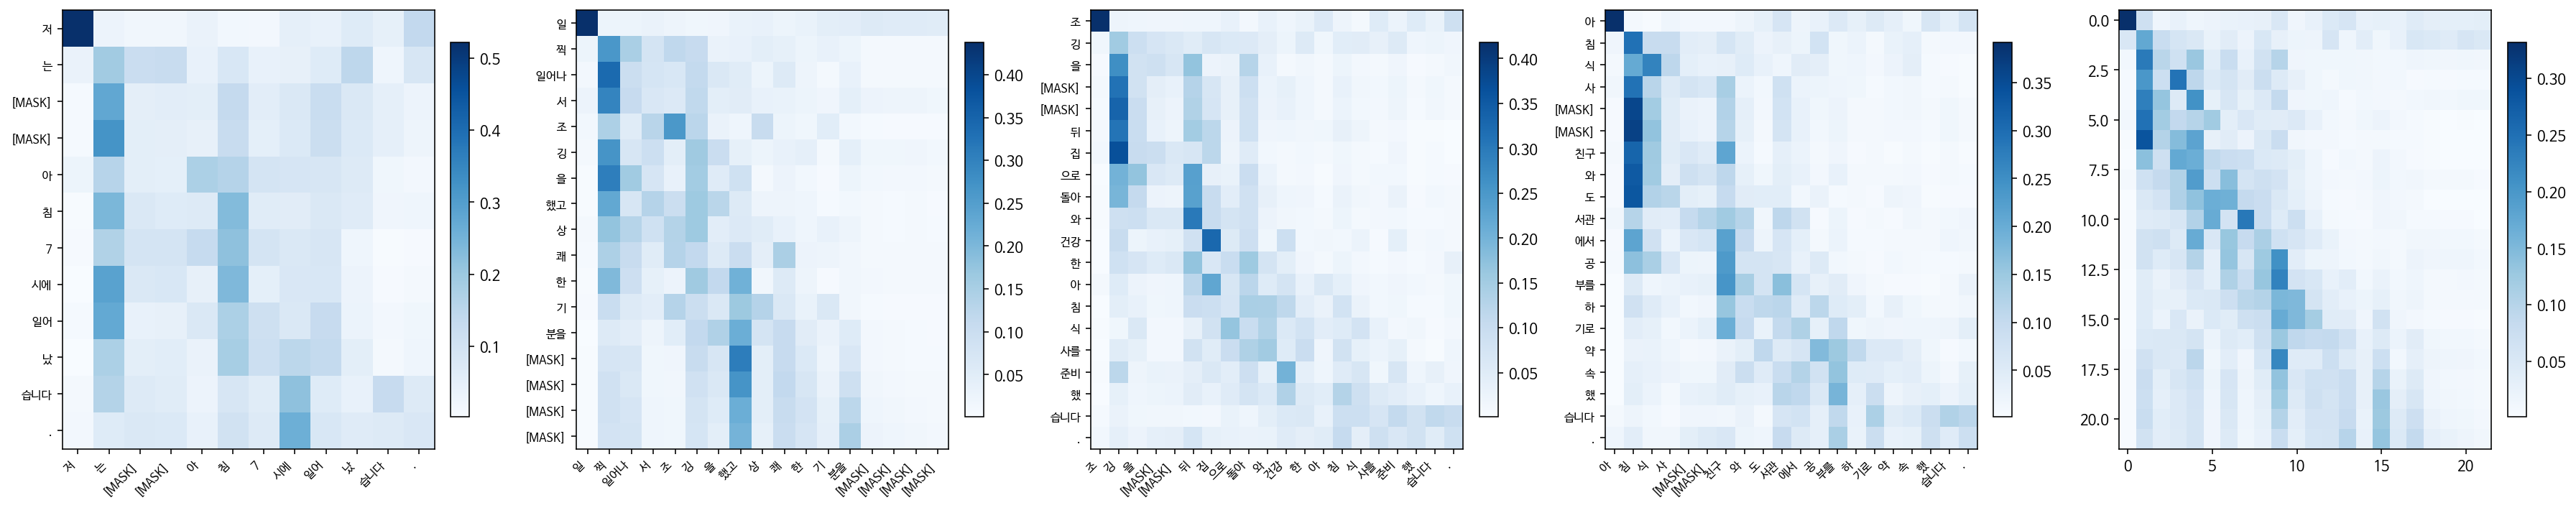

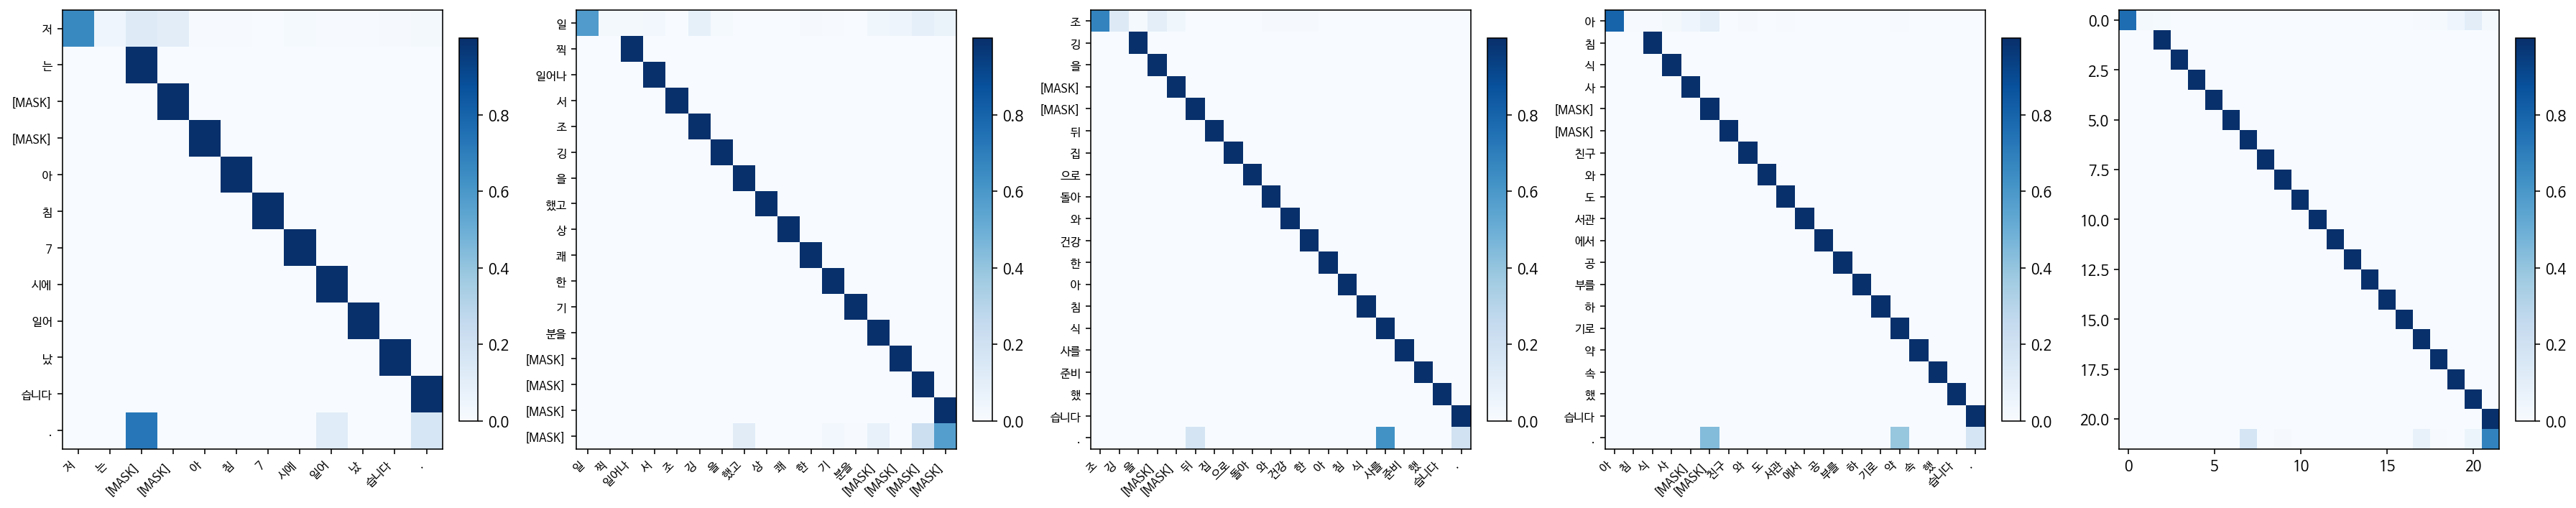

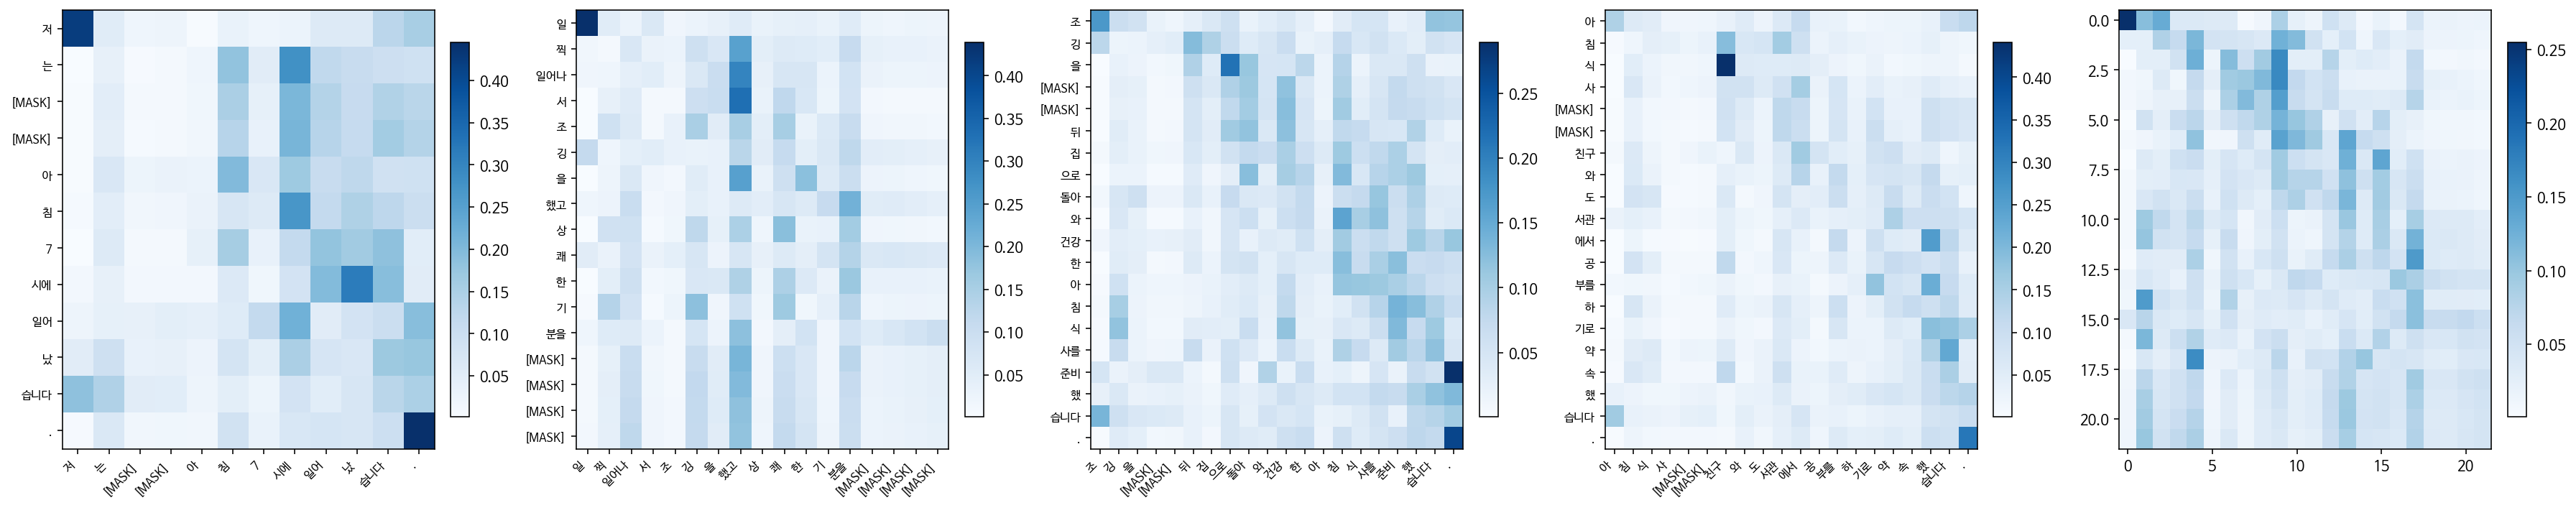

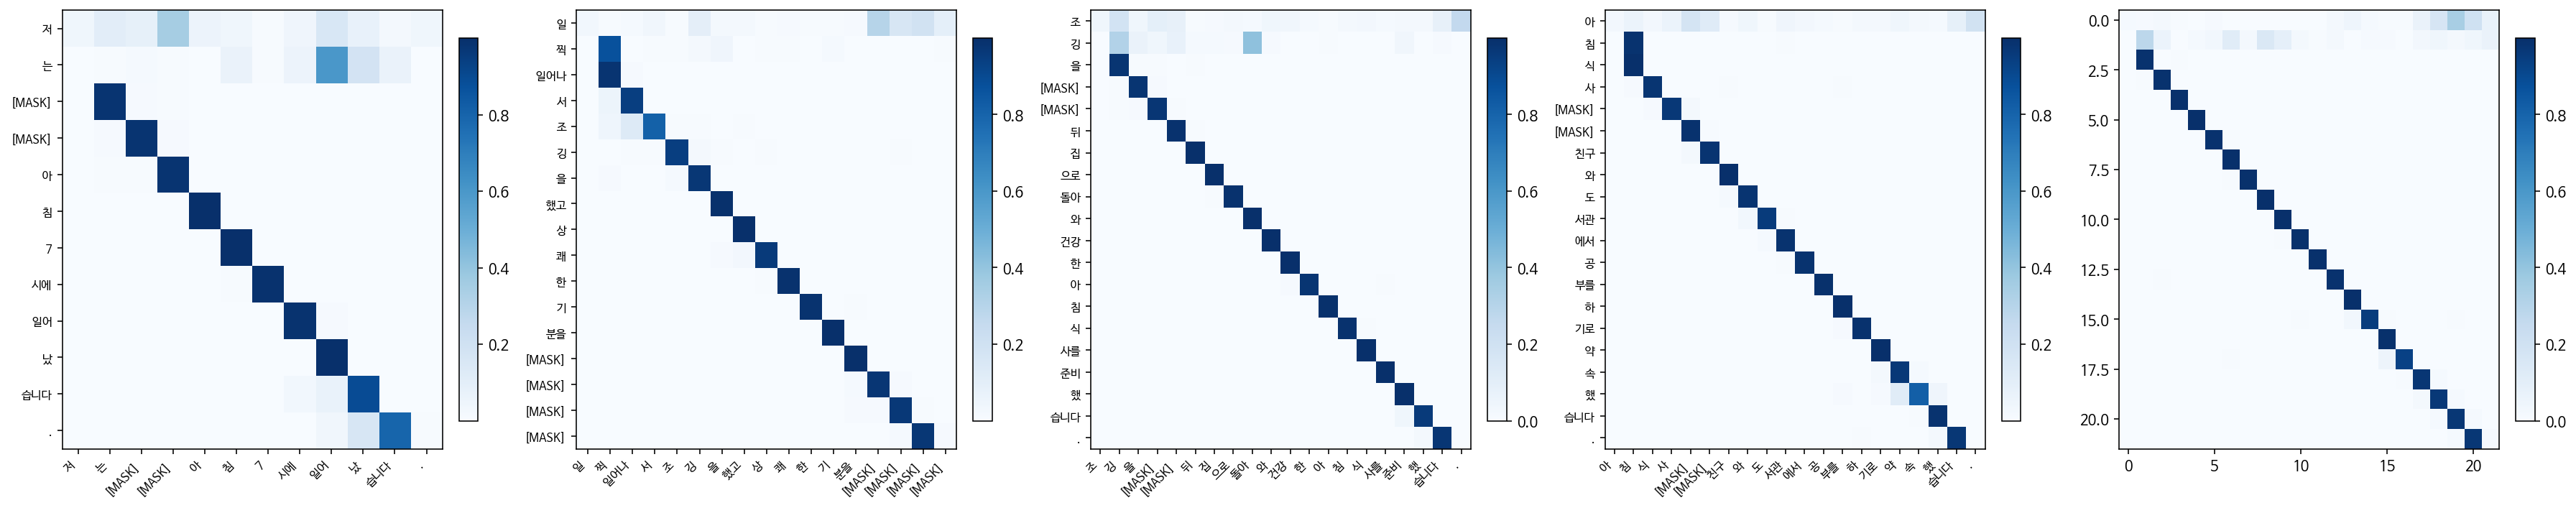


=== Masked LM 테스트: 2개 그룹 마스킹 ===

원문:   ['▁저', '는', '▁어', '제', '▁아', '침', '▁7', '시에', '▁일어', '났', '습니다', '.']
마스크: ['▁저', '는', '▁어', '제', '[MASK]', '[MASK]', '▁7', '시에', '[MASK]', '[MASK]', '[MASK]', '[MASK]']
예측:   ['▁7', '시에', '시에', '시에', '(', '▁어']

원문:   ['▁일', '찍', '▁일어나', '서', '▁조', '깅', '을', '▁했고', '▁상', '쾌', '한', '▁기', '분을', '▁느', '꼈', '습니다', '.']
마스크: ['▁일', '찍', '▁일어나', '서', '▁조', '깅', '을', '▁했고', '[MASK]', '[MASK]', '[MASK]', '▁기', '분을', '[MASK]', '[MASK]', '[MASK]', '[MASK]']
예측:   ['▁', '어', '.', '.', '▁조', '깅', '의']

원문:   ['▁조', '깅', '을', '▁마', '친', '▁뒤', '▁집', '으로', '▁돌아', '와', '▁건강', '한', '▁아', '침', '▁식', '사를', '▁준비', '했', '습니다', '.']
마스크: ['▁조', '깅', '을', '[MASK]', '[MASK]', '▁뒤', '▁집', '으로', '▁돌아', '와', '▁건강', '한', '▁아', '침', '▁식', '사를', '[MASK]', '[MASK]', '[MASK]', '[MASK]']
예측:   ['▁', '고', '.', '.', '▁마', '한']

원문:   ['▁아', '침', '▁식', '사', '▁후', '에는', '▁친구', '와', '▁도', '서관', '에서', '▁공', '부를', '▁하', '기로', '▁약', '속', '했', '습니다', '.']
마스크: ['▁아', '침', '[MASK]', '[M

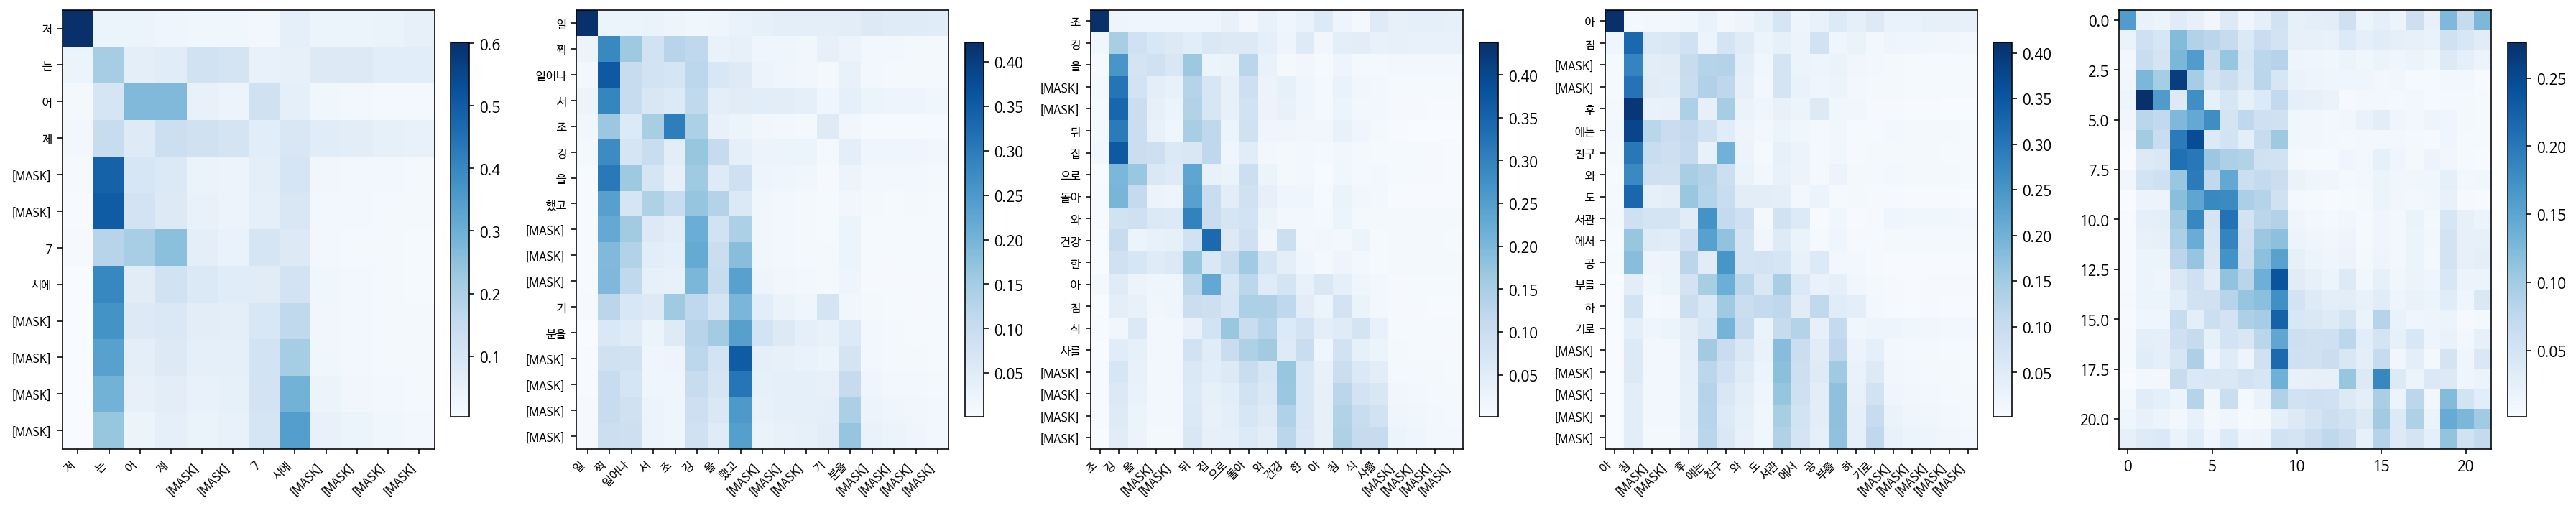

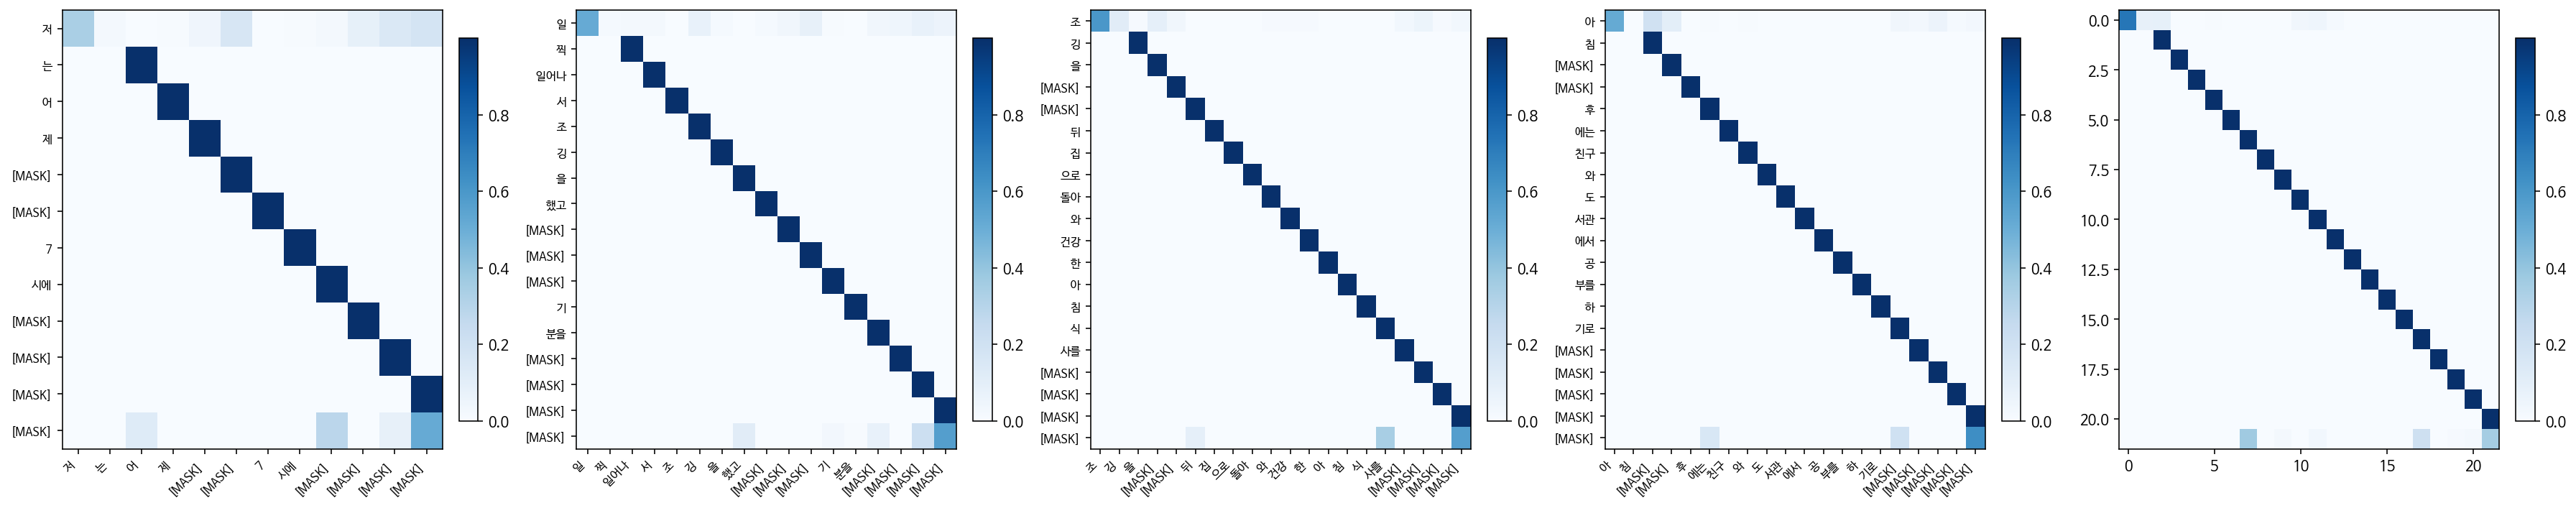

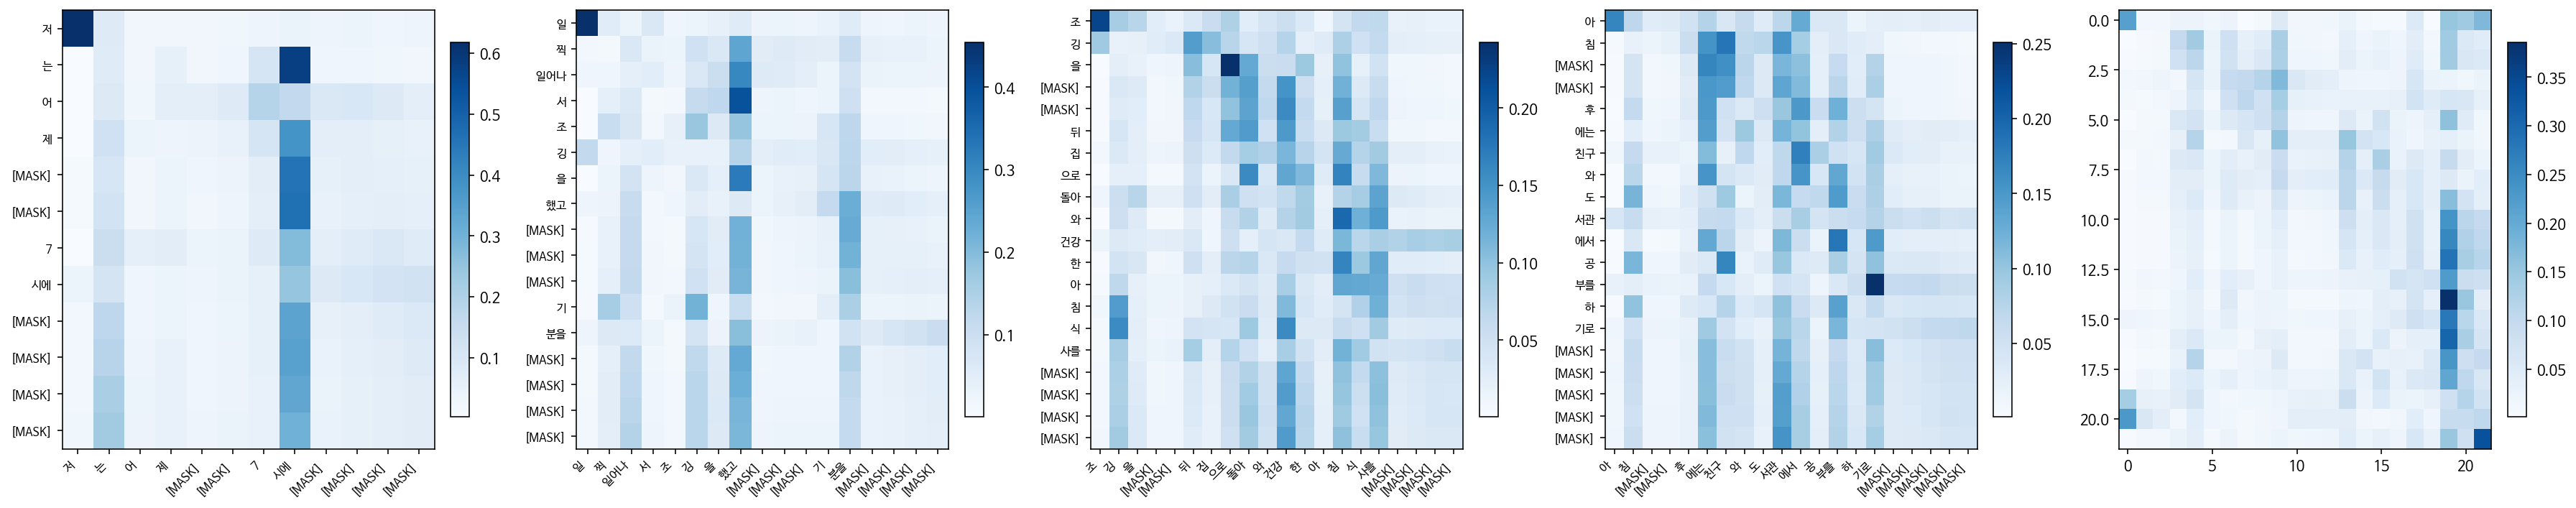

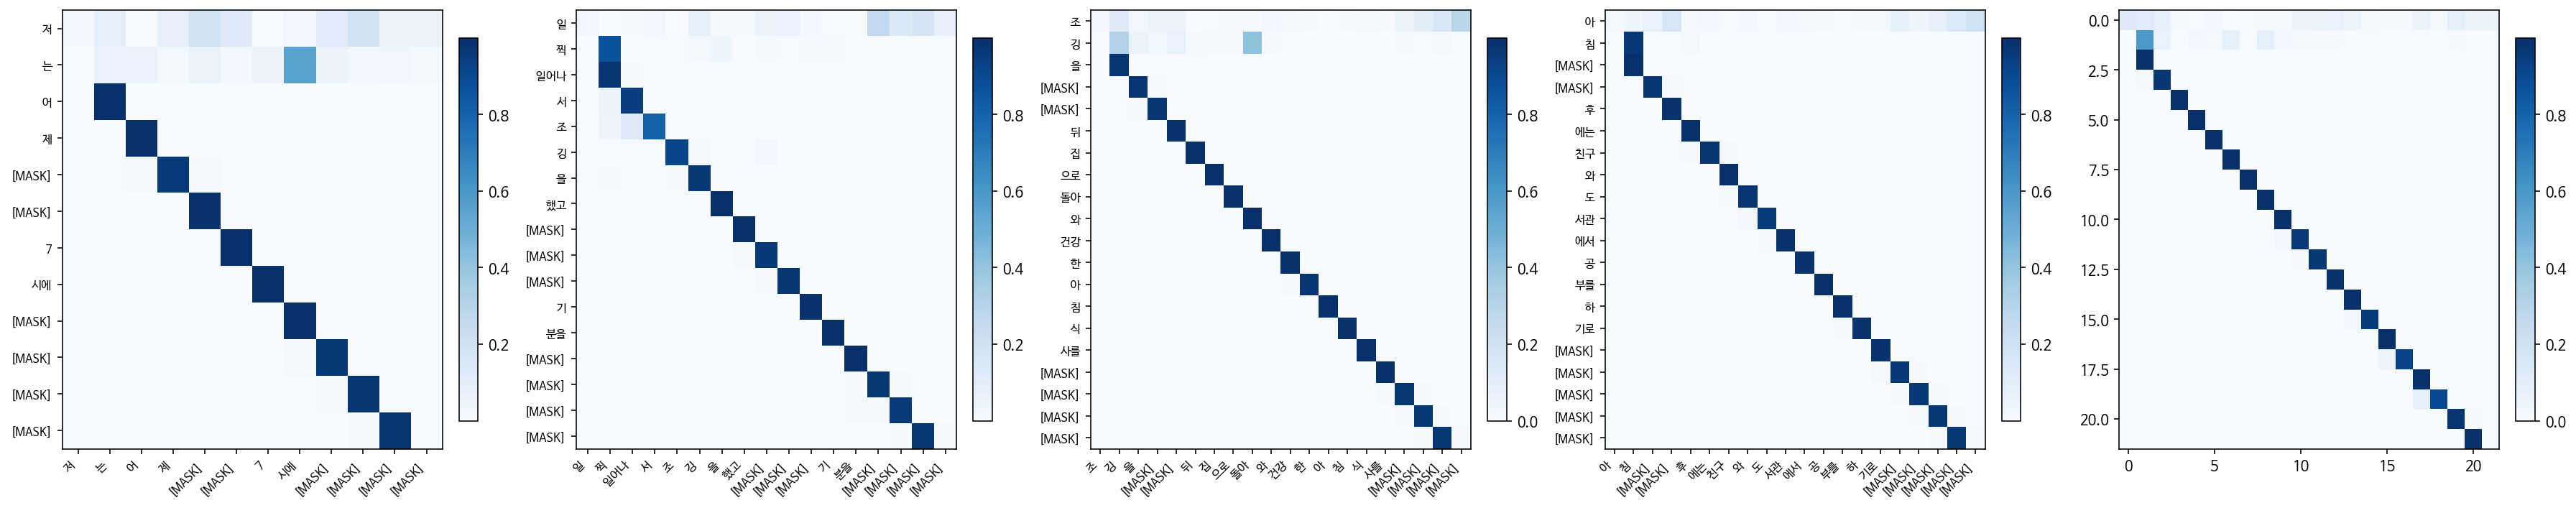


=== NSP 테스트 ===
T 0->1: 0.51
T 1->2: 0.51
T 2->3: 0.51
T 3->4: 0.51
F 0->4: 0.50
F 1->1: 0.52
F 2->0: 0.51
F 3->3: 0.50
NSP 정확도: True 4/4, False 2/4


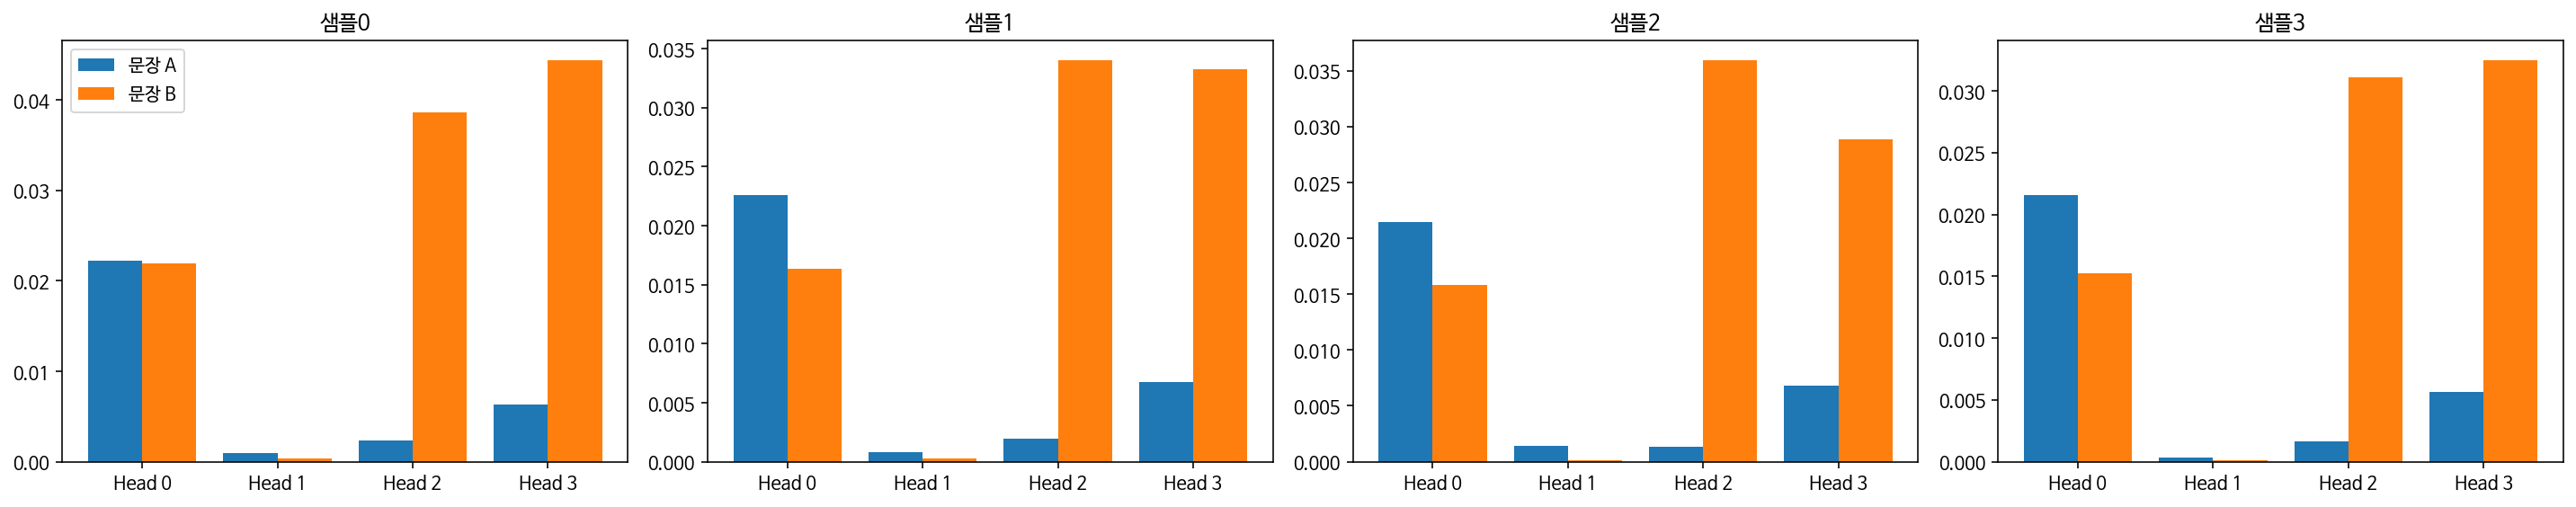

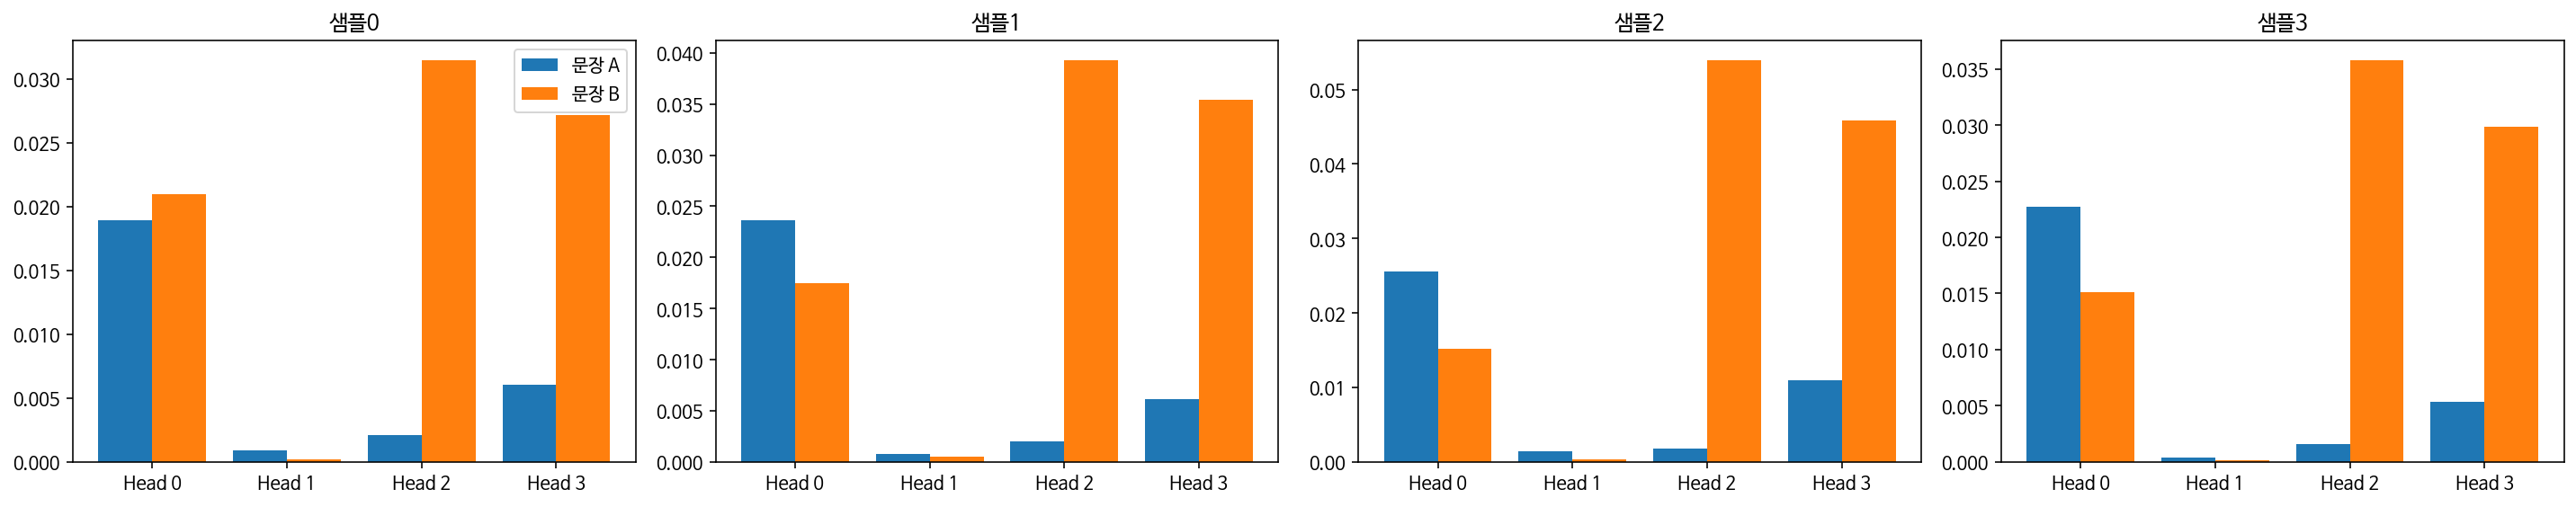

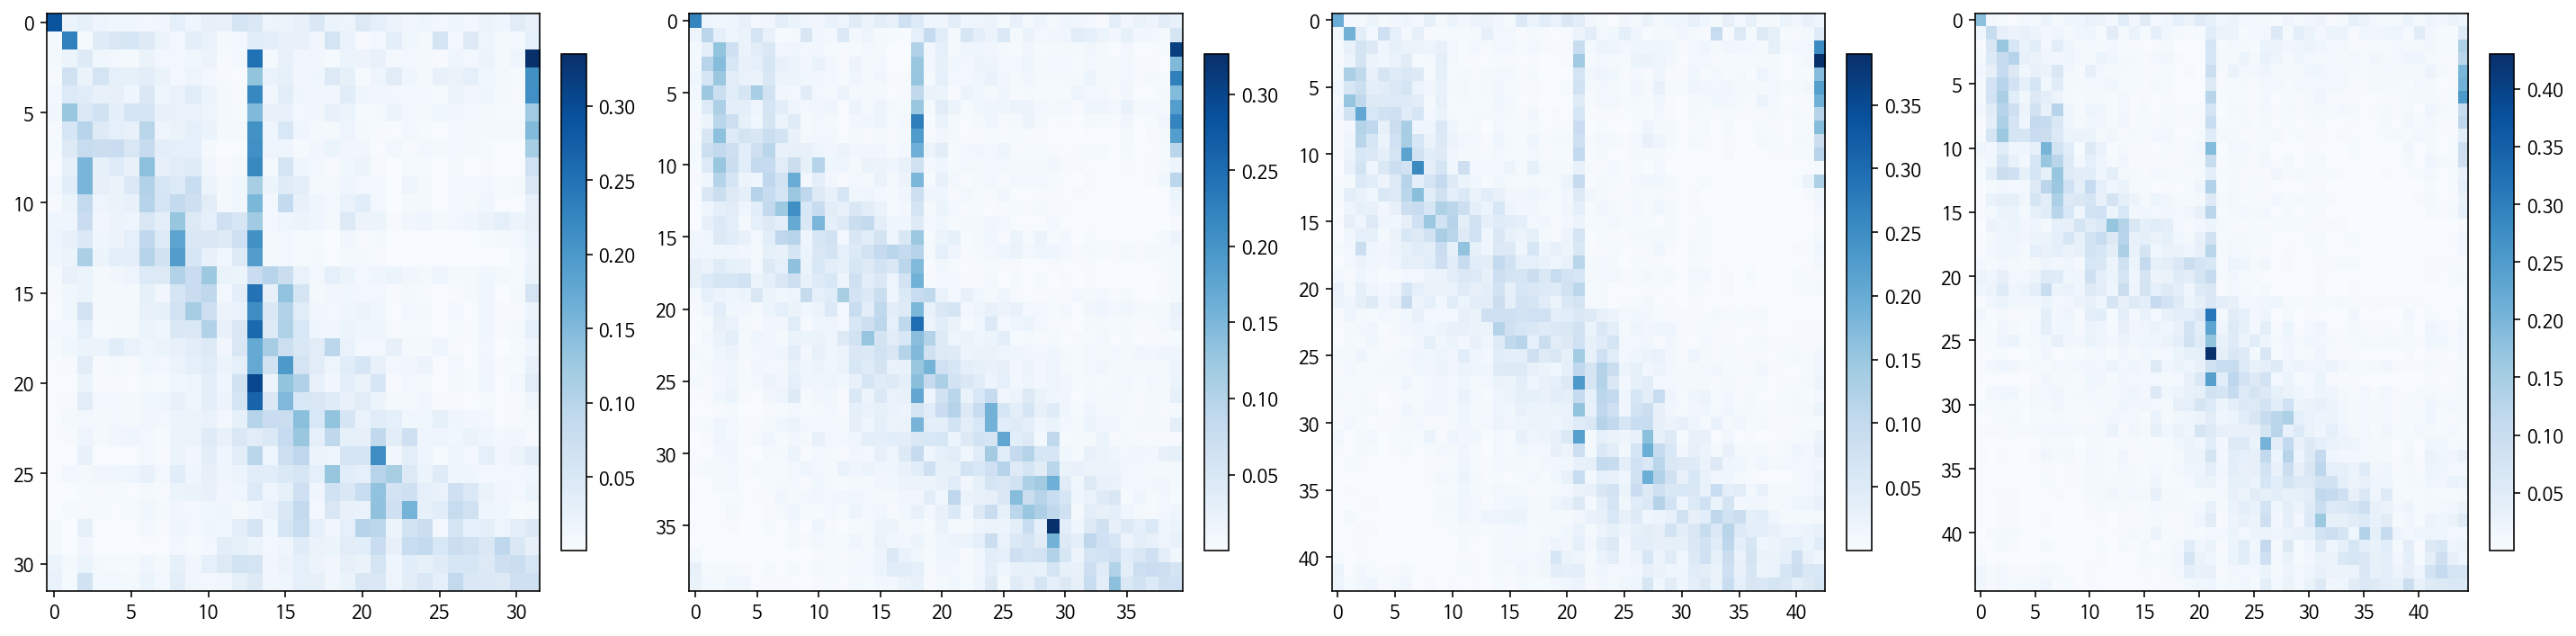

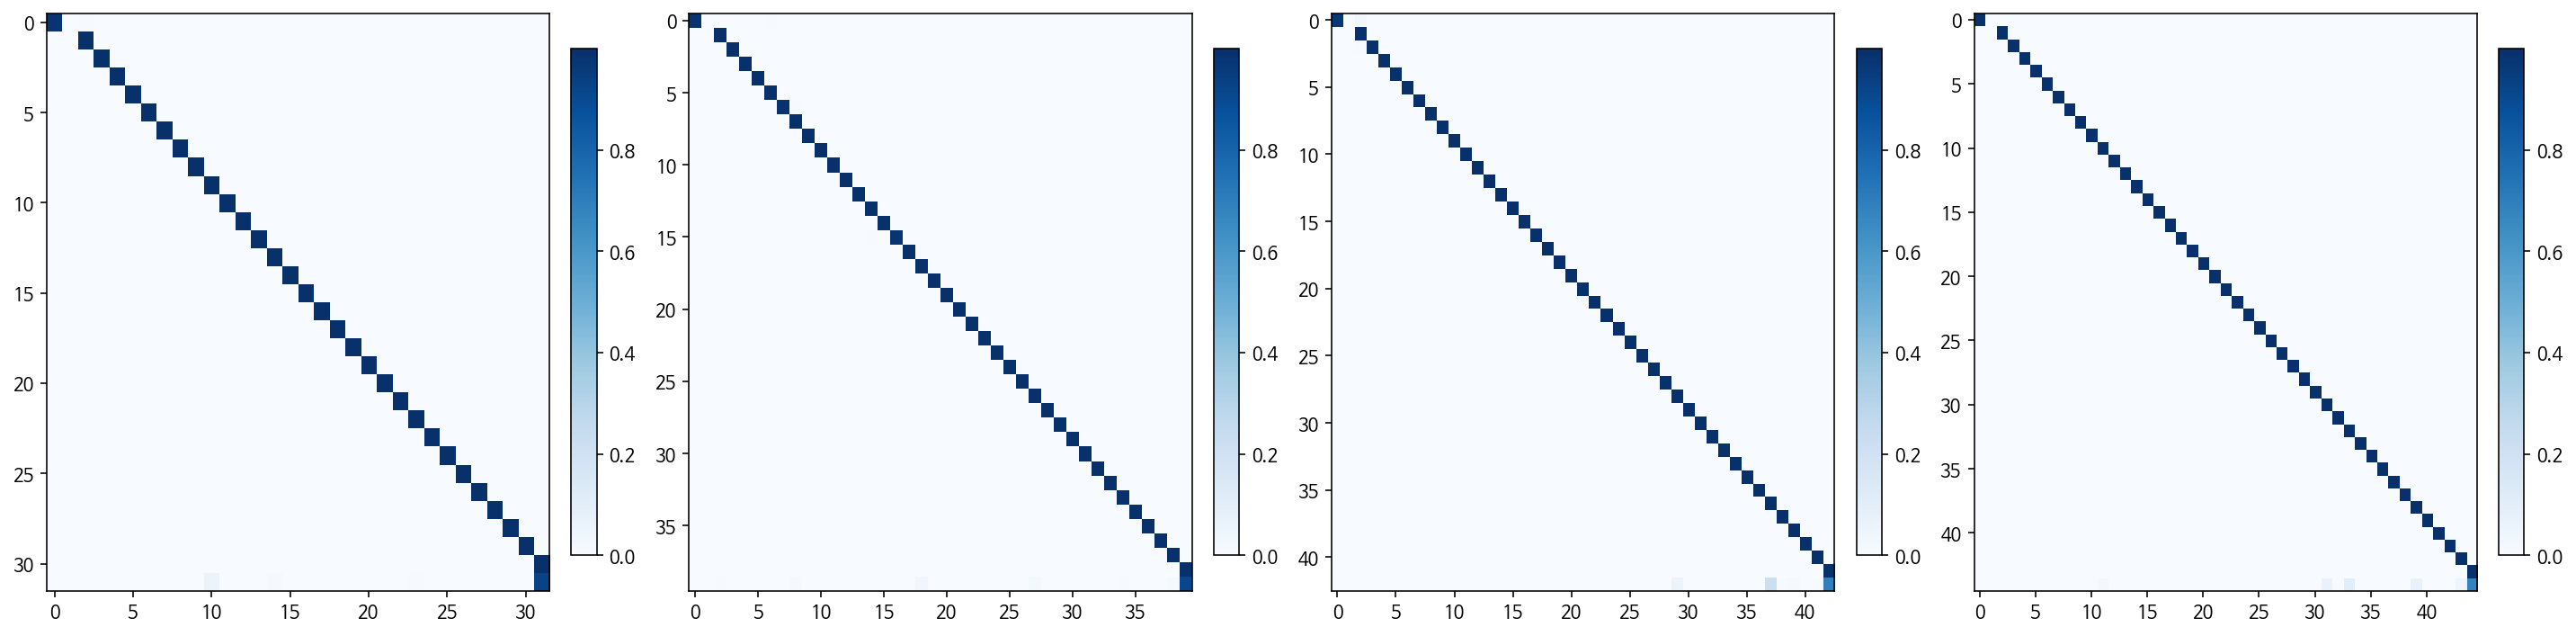

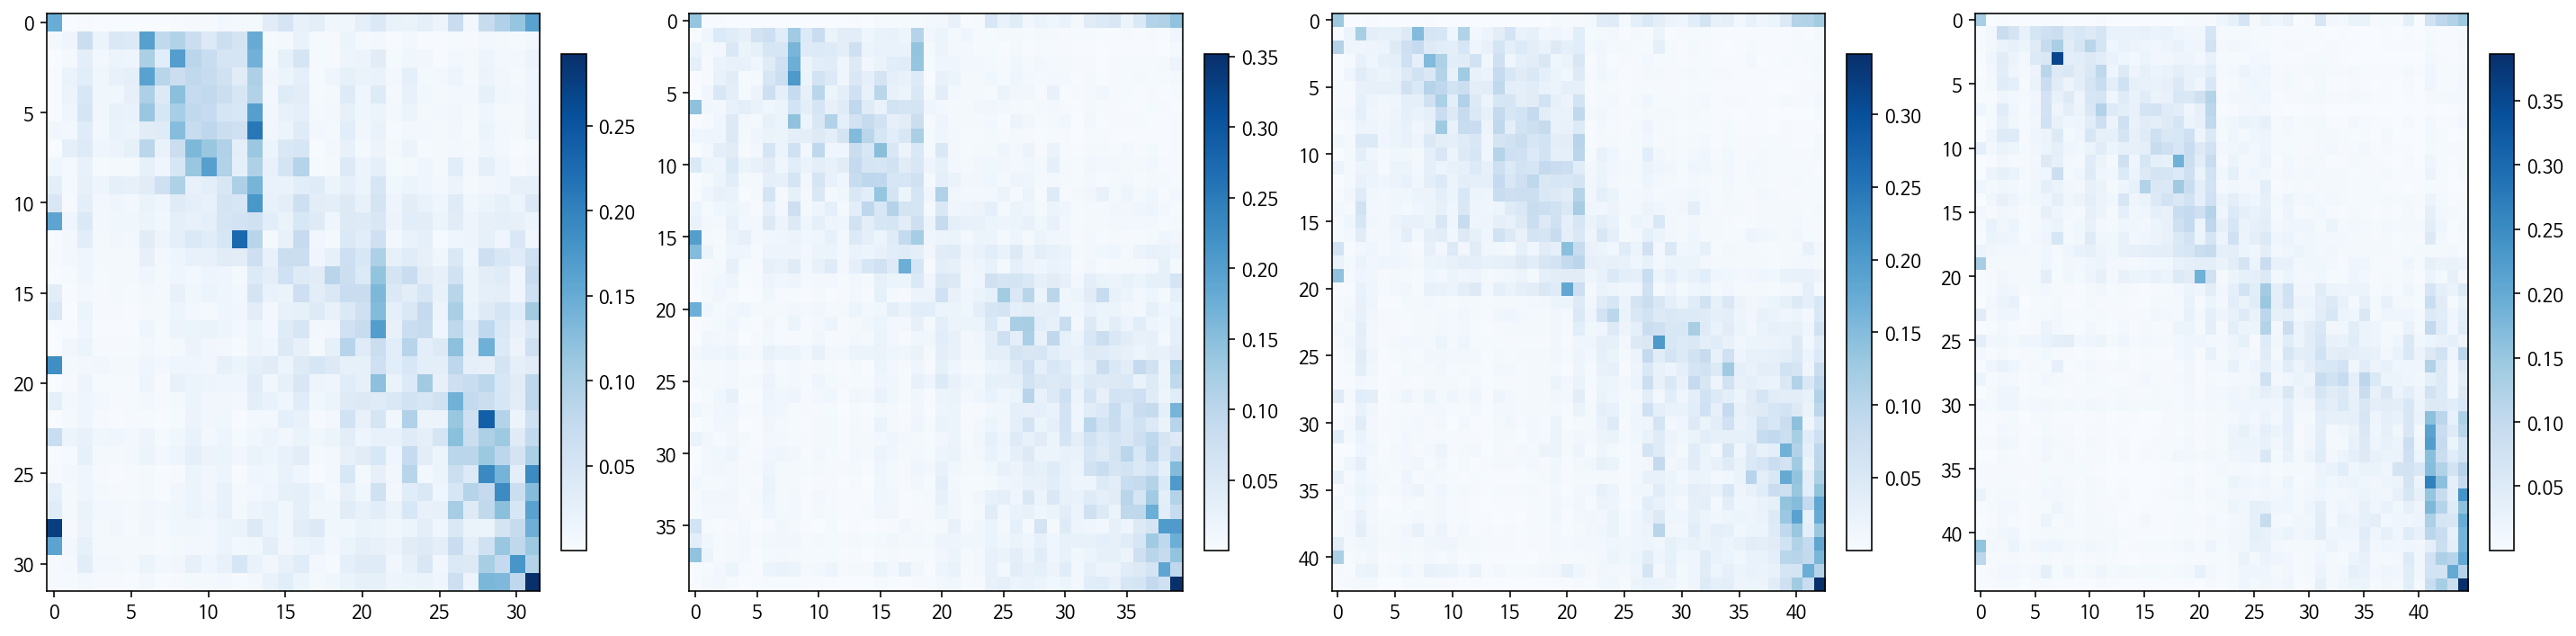

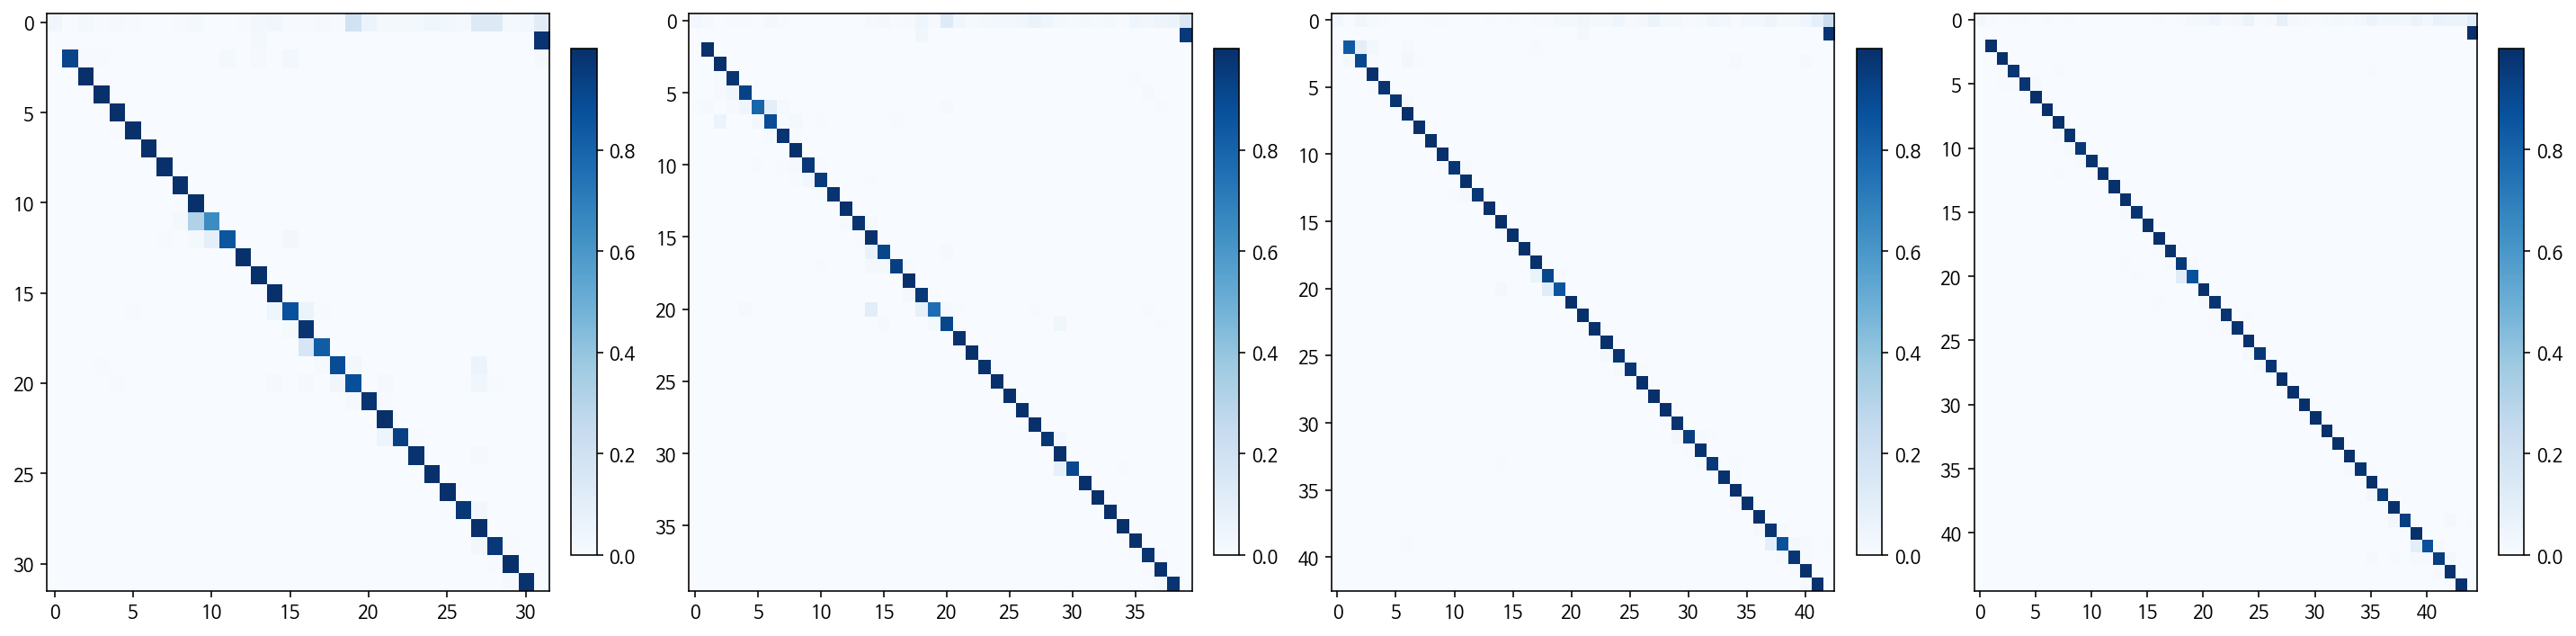

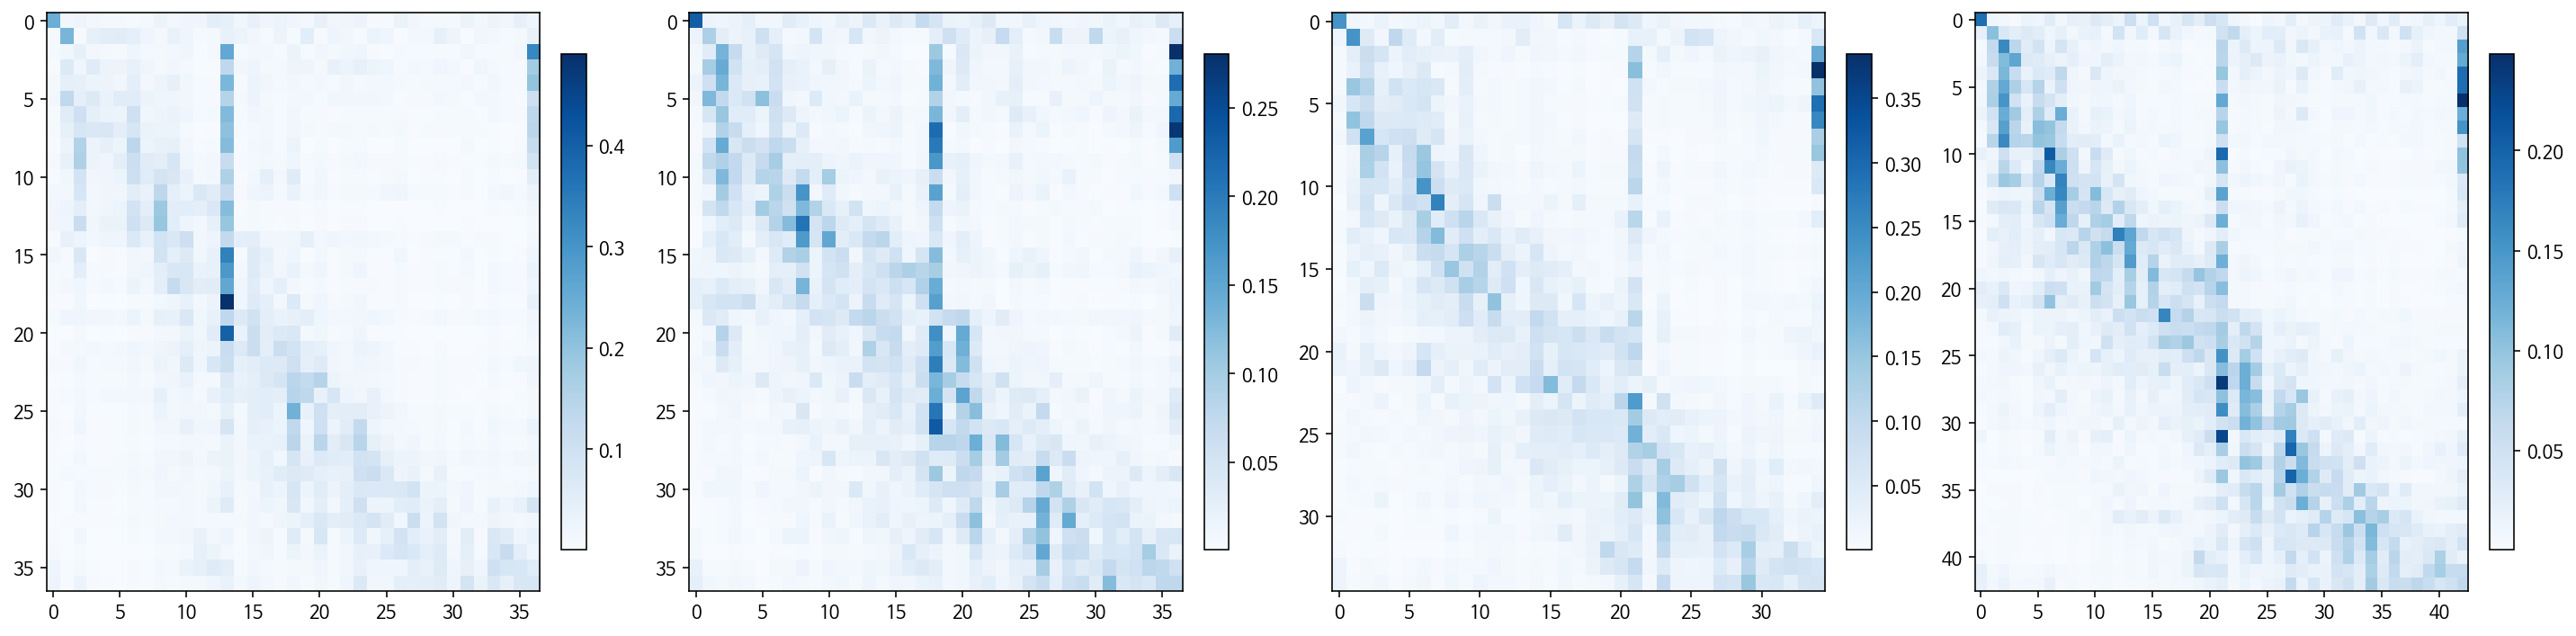

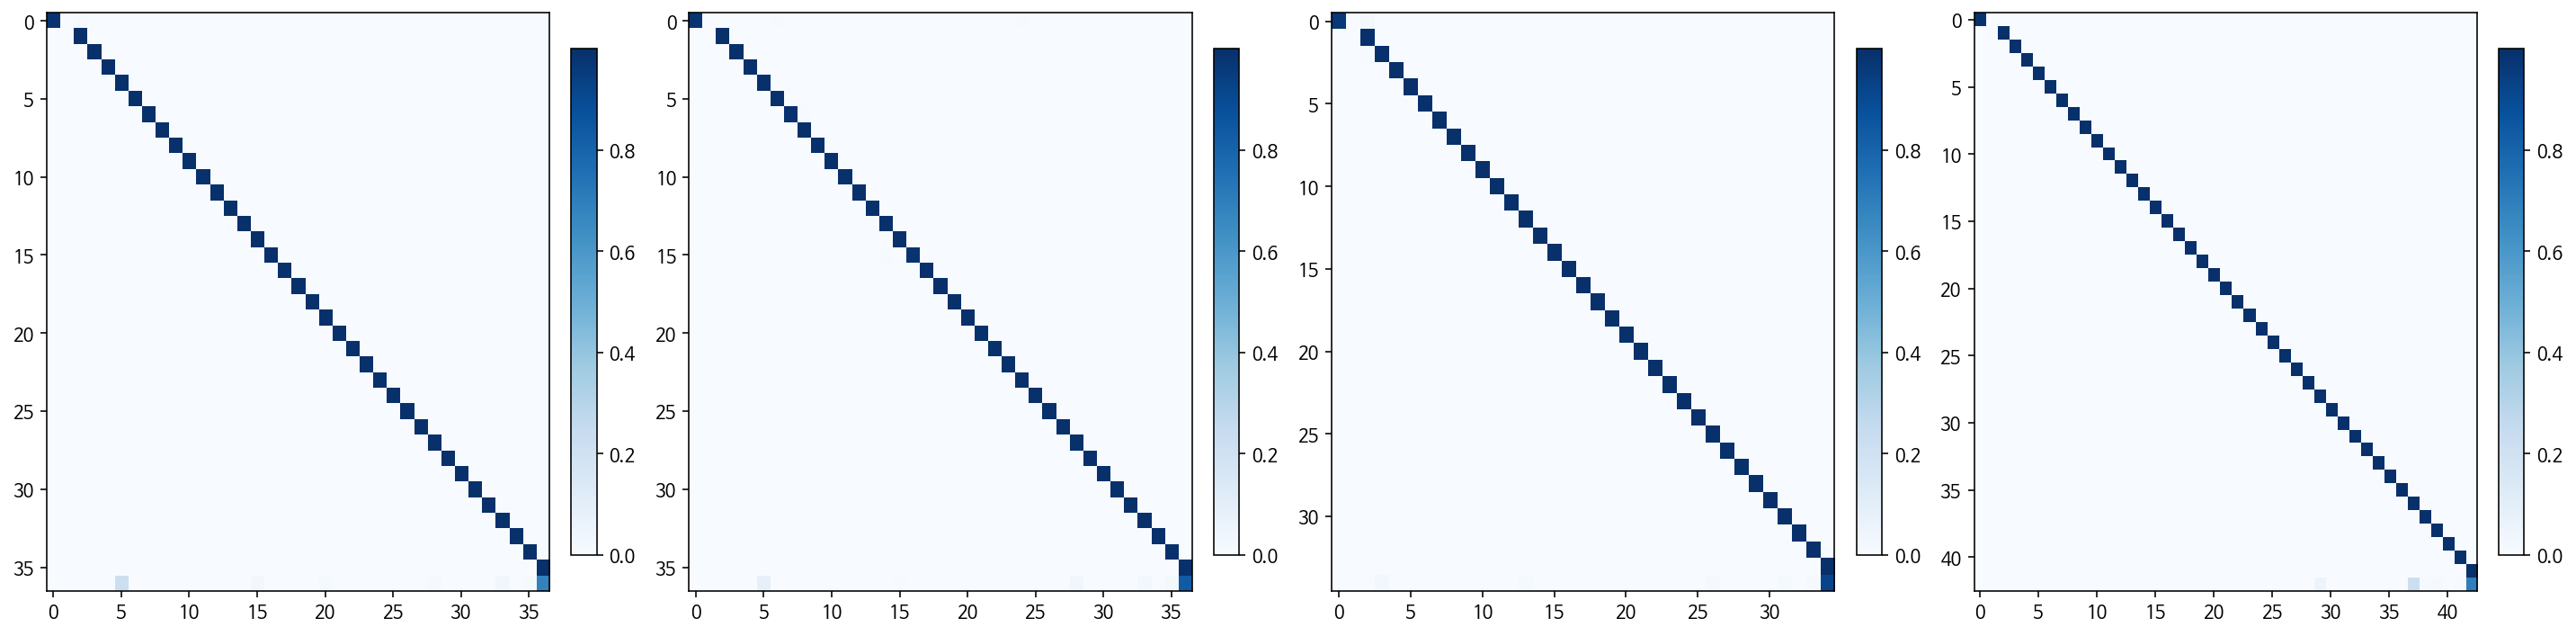

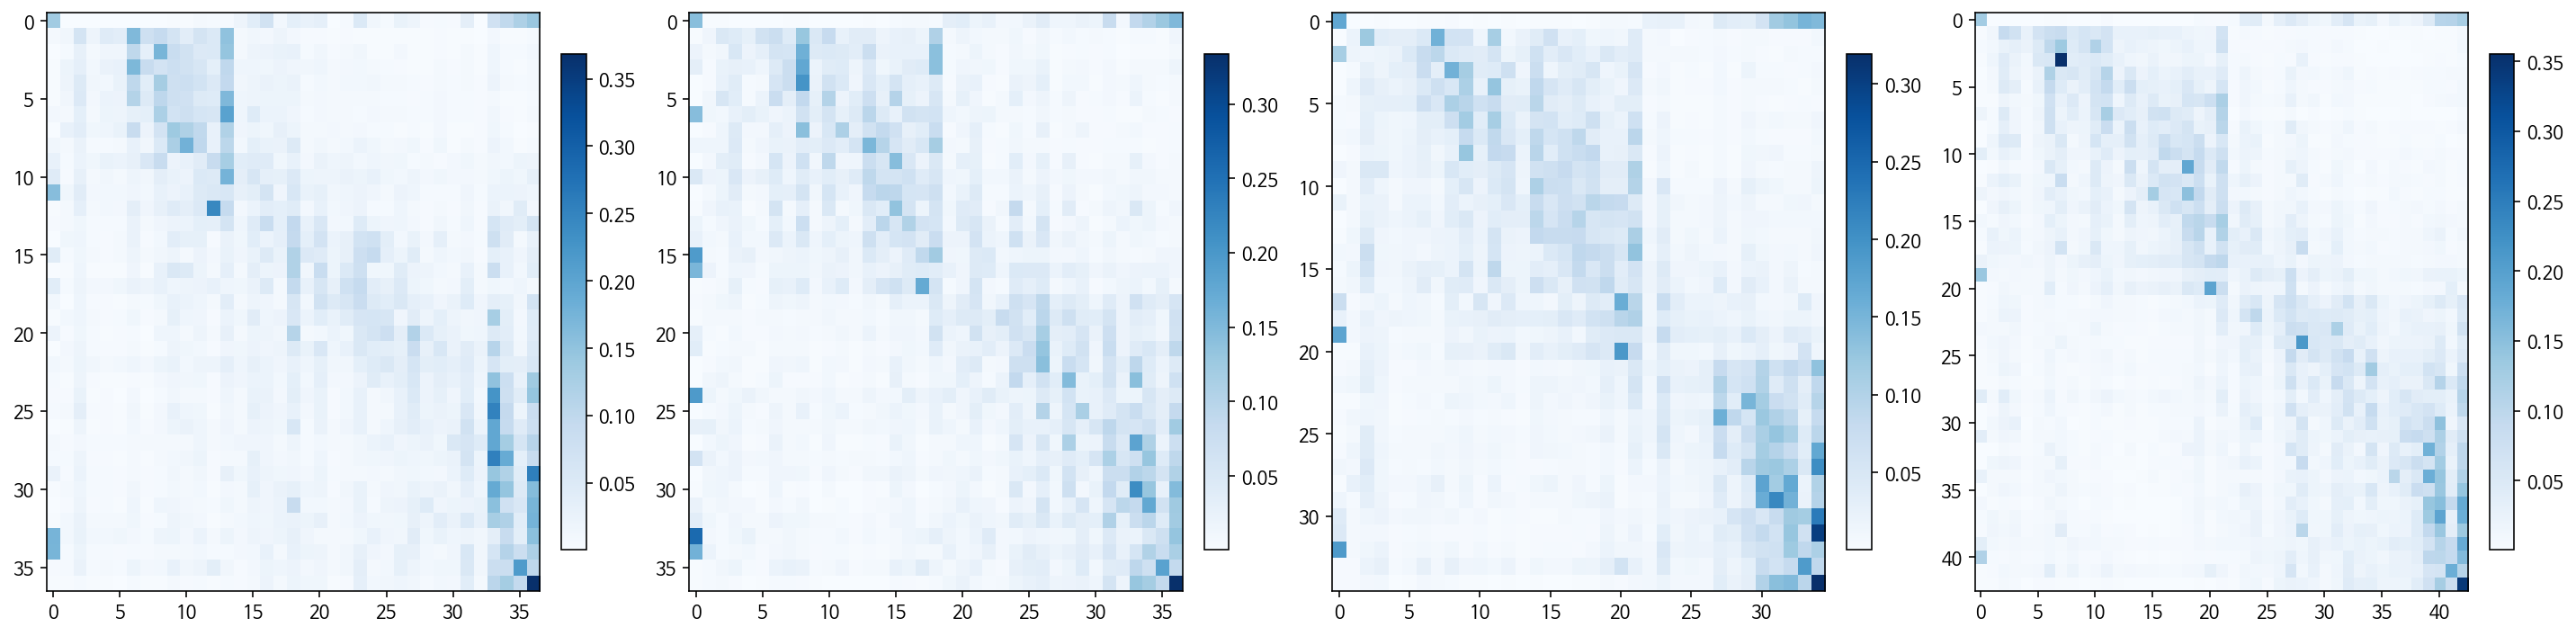

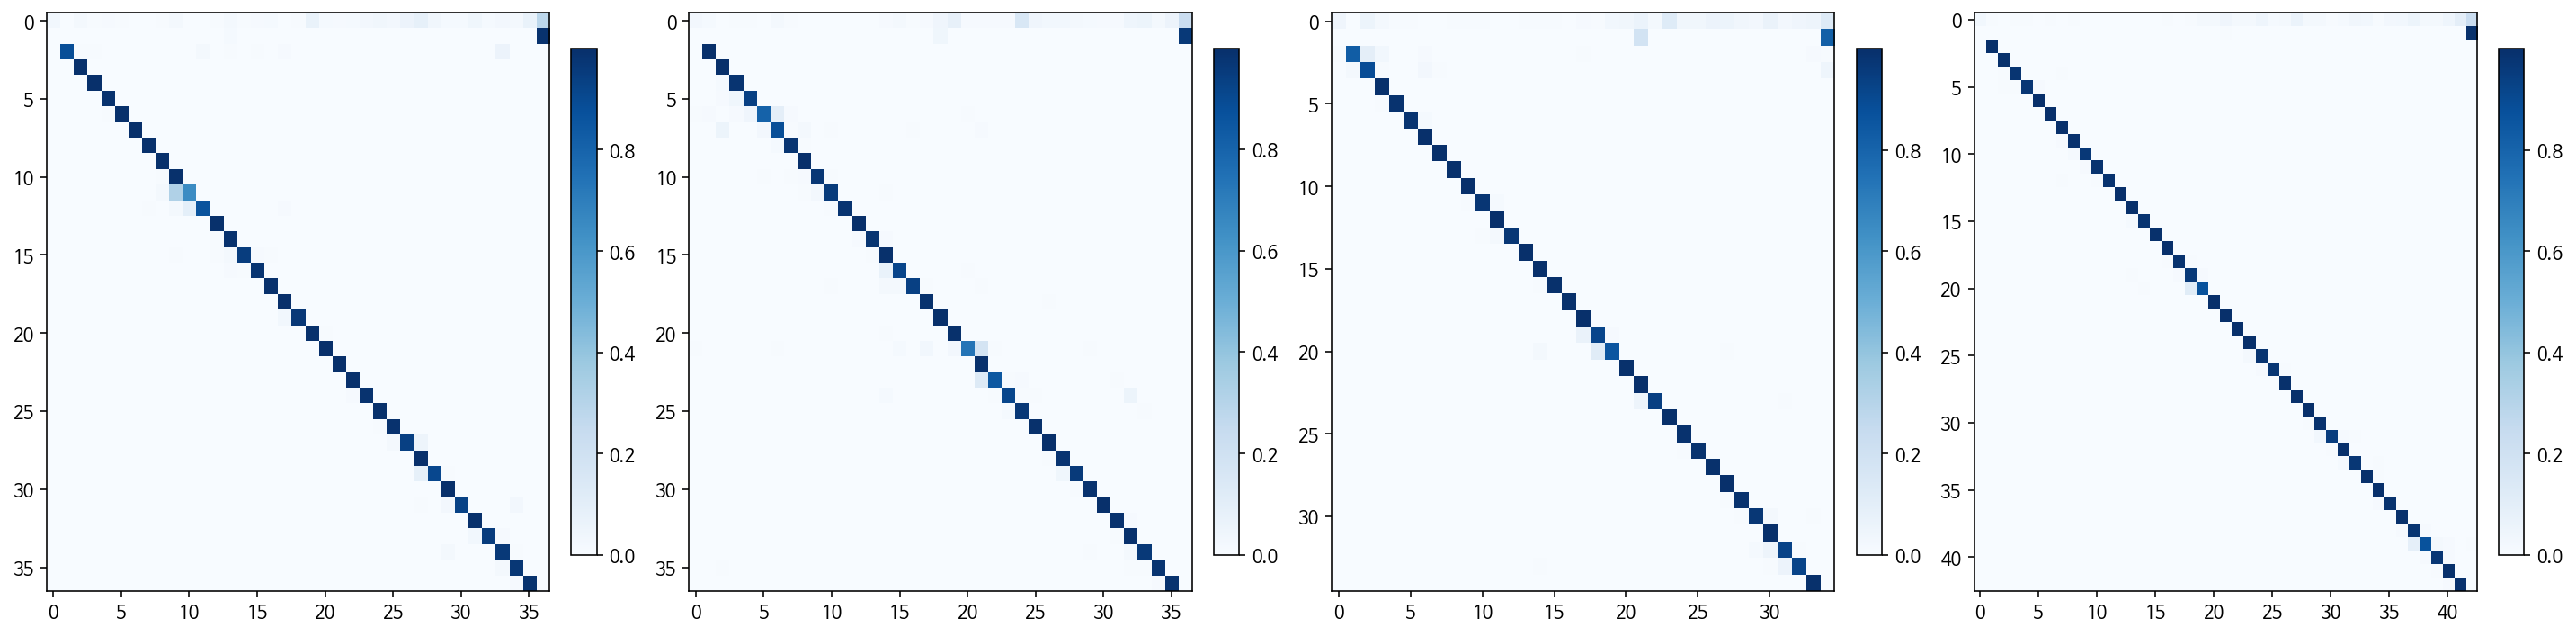

In [92]:
paragraph = """저는 어제 아침 7시에 일어났습니다.
일찍 일어나서 조깅을 했고 상쾌한 기분을 느꼈습니다.
조깅을 마친 뒤 집으로 돌아와 건강한 아침 식사를 준비했습니다.
아침 식사 후에는 친구와 도서관에서 공부를 하기로 약속했습니다.
도서관에서 집중해서 공부를 마친 뒤 카페에 들러 커피를 마셨습니다."""
test_pretrain_model(paragraph, model, vocab)

## 결과 분석
- 실습보다 작은 vocab 사이즈 사용으로 서브워드 분할이 많아진 것을 알 수 있다.
    - OOV 가 줄어들 가능성이 있지만 서브워드 분할이 지나치게 되어 토큰이 의미 단위를 파악하기 힘들어질 수 있음
    - vocab이 줄어 연산 비용이 줄어들지만, 학습 데이터를 전체를 사용하도록 변경하여 90만건 이상을 사용하면서 학습 시간은 오히려 증가함 ( 약 5~6시간 )
- Masked LM 테스트 결과
    - 0%에서 30%정도의 정확도 결과가 나온다.
    - 실제로 예측 결과를 보면 크게 의미 없는 수준으로 못맞추는 것을 알 수 있다. ( 단어 단위로 봤을때는 0%에 가깝다 )
    - 추론 함수를 작성하다가 띄어쓰기가 아닌 토큰 단위로 예측하도록 잘못 작성했었는데 그때는 어느정도 토큰들을 맞춤
    - 지나치게 작은 서브워드 분할로 인해 단어의 의미를 제대로 파악하지 못하고 있는것이 아닌가 함
    - 마스크를 2개를 넣는 경우 예측 결과가 안좋은 경우가 더 많아지는 것과 비슷하다고 생각하여 2개 단어 마스킹 테스트했으나 유의미한 상관관계는 파악하지 못함 ( 정상 동작하는 경우에 연속 2개 마스크에 대한 결과를 확인해봐야 의미가 있을듯 함 )
    - Attention MAP을 그려 MASK 토큰이 어디에 집중하는지 확인
        - head 평균을 그린 경우 비슷한 모양이 출력되어 head 별로 attention map 출력
            - 1번과 3번 헤드의 경우 토큰 바로 뒷단어와 앞단어를 중점적으로 확인하도록 학습되어 보인다. 
                - 이로 인해 평균시 2줄의 비슷한 패턴이 보인듯함
            - 0번은 좀 더 앞부분에 중점을 두고 토큰들을 살피고 2번은 뒷 부분에 중점을 두고 토큰을 살피는 것으로 보인다. 
- NSP 테스트 결과
    - TRUE 세트의 경우 대부분 정답, FALSE 세트의 경우는 50% 보다는 높은편인듯하지만 거의 50%에 수렴할 정도로 보임
    - 예제 문장 구성 자체가 TRUE 세트를 구성시 전 후 관계를 확실히 알 수 있는 키워드가 포함되어 있어 그런듯함
        - 즉 명확한 키워드가 있는 경우는 맞출 수 있는 정도까지는 학습이 되는 것으로 파악됨
    - FALSE 세트의 경우 거의 무작위 선택과 다를게 없는 수준의 정확도를 보이는 것으로 보아 추상적인 의미 학습은 잘 안된 것으로 보임
    - Attention map으로 의미 있는 파악은 어려움 -> CLS 토큰이 앞 뒤 문장 중 어디에 집중하는지 보기 위해 시각화 진행
    - 아주 강력한 신호가 보이지는 않으나 HEAD3에서 뒷문장에 대한 주목도가 TRUE 세트와 FALSE 세트에 차이가 있어 보임
    - 대부분 확률 값이 50% 근처인 것으로 보아 정답에 대한 확신이 부족해 보인다. (TRUE 세트에서도 비슷함 )
- 결론 
    - 서브나이즈 토크나이저에서는 vocab 사이즈가 줄면 서브워드 분할이 빈번해져 OOV가 줄어들어도 토큰의미 파악이 어려워질 수 있다.
    - 연산 비용은 줄어드나 실제 학습 효율은 알 수 없음
    - 많은 데이터도 중요하지만 언어에 맞는 적절한 vocab 구성 역시 중요하다고 생각됨

## 회고
- 잘된 부분
    - head 를 나눠 attention map을 출력해본 부분, CLS 문장 집중 관련 체크해본 부분
        - head 간의 역활이 분담되어 있는 것처럼 보여 흥미로웠음
- 아쉬운 부분
    - 모델 구성시 전체 데이터를 사용하는 것으로 착각하여 모델 학습 시간이 지나치게 길어져 비교 실험을 할 수 없었음
        - 학습이 오래걸려 자고 일어나서 결과를 보고 추가 진행할 것을 결정하려 했으나 학습 에러로 불가능 
        - 생각해본 것들 : pretrain data load 수에 따른 변화, Vocab size 에 따른 변화, Mask 비율에 따른 변화
- 문제 해결
    - 그래프모드(tf.function 사용)로 작성된 클래스의 변수를 eager 모드로 동작하는 함수에서 그대로 가져와 사용하면서 문제 발생
        - 어텐션 가중치를 가져와 사용하는 부분에서 문제 
        - 추론 함수를 그래프 모드에서 동작하도록 변경하고 attention 을 반환하도록 변경 
        - 디버깅 과정에서 tf.function 사용과 그래프 모드에 대해서 조금 더 자세히 알게됨
- 특이 사항
    - loss 기존코드와 다름  
        - AI에 질의하며 수정하는 과정에서 loss function 변경
        - loss * mask * 20 -> tf.reduce_sum(loss * mask) * 20 / tf.maximum(tf.reduce_sum(mask), 1)
        - 해당 loss 계산시 loss 계산 후 mask된 수로 평균을 구해 20배 해주는 것으로 변경되었는데 이 부분이 논리에 더 맞고 기존 코드가 pad나 unmasked 토큰이 손실에 기여할 가능성이 있다고 하는데 정확한 이해를 하진 못했으나 loss값이 가지는 의미 자체가 변경된 것은 아니고 학습 기여 정도만 차이날 것이라 판단해 그대로 진행함